In [116]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import json
import requests
import contextily as cx
from PIL import Image
from adjustText import adjust_text
import wget
import requests
import zipfile
import os
from io import BytesIO
import csv
import glob
import matplotlib.patheffects as pe
import wget

In [3]:
stops= pd.read_excel('BusStops.xlsx')
stops

mdb_source_id data_type entity_type location.country_code  \
0               12      gtfs         NaN                    US   
1               13      gtfs         NaN                    US   
2               14      gtfs         NaN                    US   
3               15      gtfs         NaN                    US   
4               16      gtfs         NaN                    US   
..             ...       ...         ...                   ...   
254           1845   gtfs-rt          tu                    US   
255           1872      gtfs         NaN                    US   
256           1910   gtfs-rt          vp                    US   
257           1911   gtfs-rt          tu                    US   
258           1912   gtfs-rt          sa                    US   

    location.subdivision_name location.municipality  \
0                  California            Long Beach   
1                  California             San Diego   
2                  California             San Diego   
3                  California         Orange County   
4                  California          Laguna Beach   
..                        ...                   ...   
254                California         San Francisco   
255                California  Santa Barbara County   
256                California            Santa Cruz   
257                California            Santa Cruz   
258                California            Santa Cruz   

                                              provider name  note  \
0                                       Avalon Transit  NaN   NaN   
1    San Diego International Airport, Metropolitan ...  NaN   NaN   
2                 North County Transit District (NCTD)  NaN   NaN   
3        Orange County Transportation Authority (OCTA)  NaN   NaN   
4                           Laguna Beach Transit (LBT)  NaN   NaN   
..                                                 ...  ...   ...   
254  San Francisco Municipal Transportation Agency ...  NaN   NaN   
255                                  Clean Air Express  NaN   NaN   
256                           Santa Cruz Metro (SCMTD)  NaN   NaN   
257                           Santa Cruz Metro (SCMTD)  NaN   NaN   
258                           Santa Cruz Metro (SCMTD)  NaN   NaN   

     static_reference  ... urls.api_key_parameter_name  \
0                 NaN  ...                         NaN   
1                 NaN  ...                         NaN   
2                 NaN  ...                         NaN   
3                 NaN  ...                         NaN   
4                 NaN  ...                         NaN   
..                ...  ...                         ...   
254              50.0  ...                     api_key   
255               NaN  ...                         NaN   
256            1211.0  ...                         NaN   
257            1211.0  ...                         NaN   
258            1211.0  ...                         NaN   

                                           urls.latest  \
0    https://storage.googleapis.com/storage/v1/b/md...   
1    https://storage.googleapis.com/storage/v1/b/md...   
2    https://storage.googleapis.com/storage/v1/b/md...   
3    https://storage.googleapis.com/storage/v1/b/md...   
4    https://storage.googleapis.com/storage/v1/b/md...   
..                                                 ...   
254                                                NaN   
255  https://storage.googleapis.com/storage/v1/b/md...   
256                                                NaN   
257                                                NaN   
258                                                NaN   

                                          urls.license  \
0                                                  NaN   
1    https://www.sdmts.com/business-center-develope...   
2                                                  NaN   
3    http://www.octa.net/News-and-Resources/Open-Da...   
4                                     

In [4]:
stops.columns

Index(['mdb_source_id', 'data_type', 'entity_type', 'location.country_code',
       'location.subdivision_name', 'location.municipality', 'provider',
       'name', 'note', 'static_reference', 'urls.direct_download',
       'urls.authentication_type', 'urls.authentication_info',
       'urls.api_key_parameter_name', 'urls.latest', 'urls.license',
       'location.bounding_box.minimum_latitude',
       'location.bounding_box.maximum_latitude',
       'location.bounding_box.minimum_longitude',
       'location.bounding_box.maximum_longitude',
       'location.bounding_box.extracted_on', 'status', 'features'],
      dtype='object')

# Creating City folders then creating Transit organizations within the city folders and upzipping/extracting data from there

In [6]:
stops.sort_values(by=['location.municipality'],ascending=True)

for city in list(stops['location.municipality'].unique()):
    print(city)
    stops_query = stops[stops['location.municipality'] == city]

    #Split URL to get the file aname
    #filename = url.split('/')[-1]

    #Creating folder based on the provider variable
    path_city = './Zip City Files/'+ city
    # Making a path based on the folder of the city variable
    os.mkdir(path_city)
    print("Done creating folder for", city)
    
    for index, row in stops_query.iterrows():
        try:
            provider = row['provider']
            city= row['location.municipality']
            url= row['urls.direct_download']
            filename = url.split('/')[-1]
            print("Donwloading.......", index, "|", city, "|",provider)
                
            #Creating folder based on the provider variable
            path_provider = path_city + "/" + provider
                
            os.mkdir(path_provider)
            
            # Downloading the file by sending the request to the URL
            req = requests.get(url)
            print('Downloading Completed')

            # extracting the zip file contents

            zip_file= zipfile.ZipFile(BytesIO(req.content))
            zip_file.extractall(path_provider)
            
            
        except Exception:
            pass

Long Beach
Done creating folder for Long Beach
Donwloading....... 0 | Long Beach | Avalon Transit
Donwloading....... 112 | Long Beach | Catalina Express
Donwloading....... 159 | Long Beach | Long Beach Transit (LBT)
Donwloading....... 234 | Long Beach | Avalon Transit
Donwloading....... 235 | Long Beach | Avalon Transit
San Diego
Done creating folder for San Diego
Donwloading....... 1 | San Diego | San Diego International Airport, Metropolitan Transit System (MTS)
Donwloading....... 2 | San Diego | North County Transit District (NCTD)
Donwloading....... 180 | San Diego | North County Transit District (NCTD)
Donwloading....... 181 | San Diego | North County Transit District (NCTD)
Donwloading....... 182 | San Diego | North County Transit District (NCTD)
Orange County
Done creating folder for Orange County
Donwloading....... 3 | Orange County | Orange County Transportation Authority (OCTA)
Donwloading....... 215 | Orange County | Orange County Transportation Authority (OCTA)
Donwloading.

# Going through each of the city folders and transportation agency folders to take the 'stop.txt' file and convert that into a dataframe to then merge with all of the other text files

In [7]:
# Specify the root folder containing the city folders
root_folder = "./Zip City Files"

# Initialize an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Iterate through each city folder
for city_folder in os.listdir(root_folder):
    city_folder_path = os.path.join(root_folder, city_folder)
    
    # Check if the item in the root folder is a directory
    if os.path.isdir(city_folder_path):
        
        # Iterate through each transportation agency folder within the city folder
        for agency_folder in os.listdir(city_folder_path):
            agency_folder_path = os.path.join(city_folder_path, agency_folder)
            
            # Check if the item in the city folder is a directory
            if os.path.isdir(agency_folder_path):
                
                # Specify the specific text file name you want to extract
                target_file = "stops.txt"
                target_file_path = os.path.join(agency_folder_path, target_file)
                
                # Check if the target file exists
                if os.path.isfile(target_file_path):
                    
                    # Read the text file into a DataFrame
                    df = pd.read_csv(target_file_path)
                    
                    # Add the "City_Name" and "Agency_Transit" fields to the DataFrame
                    df["City_Name"] = city_folder
                    df["Agency_Transit"] = agency_folder
                    
                    # Merge the DataFrame with the merged_df DataFrame
                    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Print the merged DataFrame
merged_df


stop_id stop_code platform_code                     stop_name  \
0      2619783       NaN           NaN     Valley Blvd & Almansor St   
1      2619784       NaN           NaN         Valley Blvd & Vega St   
2      2619785       NaN           NaN        Shorb St & Granada Ave   
3      2619787       NaN           NaN   Alamansor St & Los Higos St   
4      2619788       NaN           NaN   Alamansor St & Los Higos St   
...        ...       ...           ...                           ...   
87754   758936       NaN           NaN           Evelyn & Martel Dr    
87755   758937       NaN           NaN           Hansen & E 22nd St    
87756   758939       NaN           NaN    Gov't Center I St & 9th St   
87757   804148       NaN           NaN  Gray & Ainsley Ave Mall (NB)   
87758   804149       NaN           NaN  Gray & Ainsley Ave Mall (SB)   

      stop_desc   stop_lat    stop_lon zone_id  \
0           NaN  34.079011 -118.117346     NaN   
1           NaN  34.079282 -118.111602     NaN   
2           NaN  34.080835 -118.114294     NaN   
3           NaN  34.085540 -118.116863     NaN   
4           NaN  34.085874 -118.117052     NaN   
...         ...        ...         ...     ...   
87754       NaN  39.078708 -121.537239     NaN   
87755       NaN  39.159549 -121.566510     NaN   
87756       NaN  39.143689 -121.597317     NaN   
87757       NaN  39.144084 -121.630166     NaN   
87758       NaN  39.143797 -121.630281     NaN   

                                                stop_url  location_type  ...  \
0                                                    NaN            0.0  ...   
1                                                    NaN            0.0  ...   
2                                                    NaN            0.0  ...   
3                                                    NaN            0.0  ...   
4                                                    NaN            0.0  ...   
...                                                  ...            ...  ...   
87754                                                NaN            0.0  ...   
87755  http://www.yubasuttertransits.com/newroute4ab....            0.0  ...   
87756                                                NaN            0.0  ...   
87757                                                NaN            0.0  ...   
87758                                                NaN            0.0  ...   

      stop_place reference_place  stop_name_short  plc_url  sign_dest  \
0            NaN             NaN              NaN      NaN        NaN   
1            NaN             NaN              NaN      NaN        NaN   
2            NaN             NaN              NaN      NaN        NaN   
3            NaN             NaN              NaN      NaN        NaN   
4            NaN             NaN              NaN      NaN        NaN   
...          ...             ...              ...      ...        ...   
87754        NaN             NaN              NaN      NaN        NaN   
87755        NaN             NaN              NaN      NaN        NaN   
87756        NaN             NaN              NaN      NaN        NaN   
87757        NaN             NaN              NaN      NaN        NaN   
87758        NaN             NaN              NaN      NaN        NaN   

      city_name area_name direction_id  ext_id  ext_userfield1  
0           NaN       NaN          NaN     NaN             NaN  
1           NaN       NaN          NaN     NaN             NaN  
2           NaN       NaN          NaN     NaN             NaN  
3           NaN       NaN          NaN     NaN             NaN  
4           NaN       NaN          NaN     NaN             NaN  
...         ...       ...          ...     ...             ...  
87754       NaN       NaN          NaN     NaN             NaN  
87755       NaN       NaN          NaN     NaN             NaN  
87756       NaN       NaN          NaN     NaN             NaN  
87757       NaN       NaN          NaN     NaN       

In [8]:
merged_df_new =  merged_df[['stop_name', 'stop_lat','stop_lon','Agency_Transit', 'City_Name']]
merged_df_new

stop_name   stop_lat    stop_lon  \
0         Valley Blvd & Almansor St  34.079011 -118.117346   
1             Valley Blvd & Vega St  34.079282 -118.111602   
2            Shorb St & Granada Ave  34.080835 -118.114294   
3       Alamansor St & Los Higos St  34.085540 -118.116863   
4       Alamansor St & Los Higos St  34.085874 -118.117052   
...                             ...        ...         ...   
87754           Evelyn & Martel Dr   39.078708 -121.537239   
87755           Hansen & E 22nd St   39.159549 -121.566510   
87756    Gov't Center I St & 9th St  39.143689 -121.597317   
87757  Gray & Ainsley Ave Mall (NB)  39.144084 -121.630166   
87758  Gray & Ainsley Ave Mall (SB)  39.143797 -121.630281   

                   Agency_Transit  City_Name  
0      Alhambra Community Transit   Alhambra  
1      Alhambra Community Transit   Alhambra  
2      Alhambra Community Transit   Alhambra  
3      Alhambra Community Transit   Alhambra  
4      Alhambra Community Transit   Alhambra  
...                           ...        ...  
87754         Yuba-Sutter Transit  Yuba City  
87755         Yuba-Sutter Transit  Yuba City  
87756         Yuba-Sutter Transit  Yuba City  
87757         Yuba-Sutter Transit  Yuba City  
87758         Yuba-Sutter Transit  Yuba City  

[87759 rows x 5 columns]

In [9]:
gdf = gpd.GeoDataFrame(
    merged_df_new, crs="EPSG:4326", geometry=gpd.points_from_xy(x=merged_df_new.stop_lon, y=merged_df_new.stop_lat)
)
gdf

stop_name   stop_lat    stop_lon  \
0         Valley Blvd & Almansor St  34.079011 -118.117346   
1             Valley Blvd & Vega St  34.079282 -118.111602   
2            Shorb St & Granada Ave  34.080835 -118.114294   
3       Alamansor St & Los Higos St  34.085540 -118.116863   
4       Alamansor St & Los Higos St  34.085874 -118.117052   
...                             ...        ...         ...   
87754           Evelyn & Martel Dr   39.078708 -121.537239   
87755           Hansen & E 22nd St   39.159549 -121.566510   
87756    Gov't Center I St & 9th St  39.143689 -121.597317   
87757  Gray & Ainsley Ave Mall (NB)  39.144084 -121.630166   
87758  Gray & Ainsley Ave Mall (SB)  39.143797 -121.630281   

                   Agency_Transit  City_Name                     geometry  
0      Alhambra Community Transit   Alhambra  POINT (-118.11735 34.07901)  
1      Alhambra Community Transit   Alhambra  POINT (-118.11160 34.07928)  
2      Alhambra Community Transit   Alhambra  POINT (-118.11429 34.08083)  
3      Alhambra Community Transit   Alhambra  POINT (-118.11686 34.08554)  
4      Alhambra Community Transit   Alhambra  POINT (-118.11705 34.08587)  
...                           ...        ...                          ...  
87754         Yuba-Sutter Transit  Yuba City  POINT (-121.53724 39.07871)  
87755         Yuba-Sutter Transit  Yuba City  POINT (-121.56651 39.15955)  
87756         Yuba-Sutter Transit  Yuba City  POINT (-121.59732 39.14369)  
87757         Yuba-Sutter Transit  Yuba City  POINT (-121.63017 39.14408)  
87758         Yuba-Sutter Transit  Yuba City  POINT (-121.63028 39.14380)  

[87759 rows x 6 columns]

In [27]:
gdf.dtypes

stop_name           object
stop_lat           float64
stop_lon           float64
Agency_Transit      object
City_Name           object
geometry          geometry
dtype: object

In [10]:
gdf.to_csv('Merged Bus Stops with Geometries.csv', index=False)

# Bus Stops in California

In [11]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

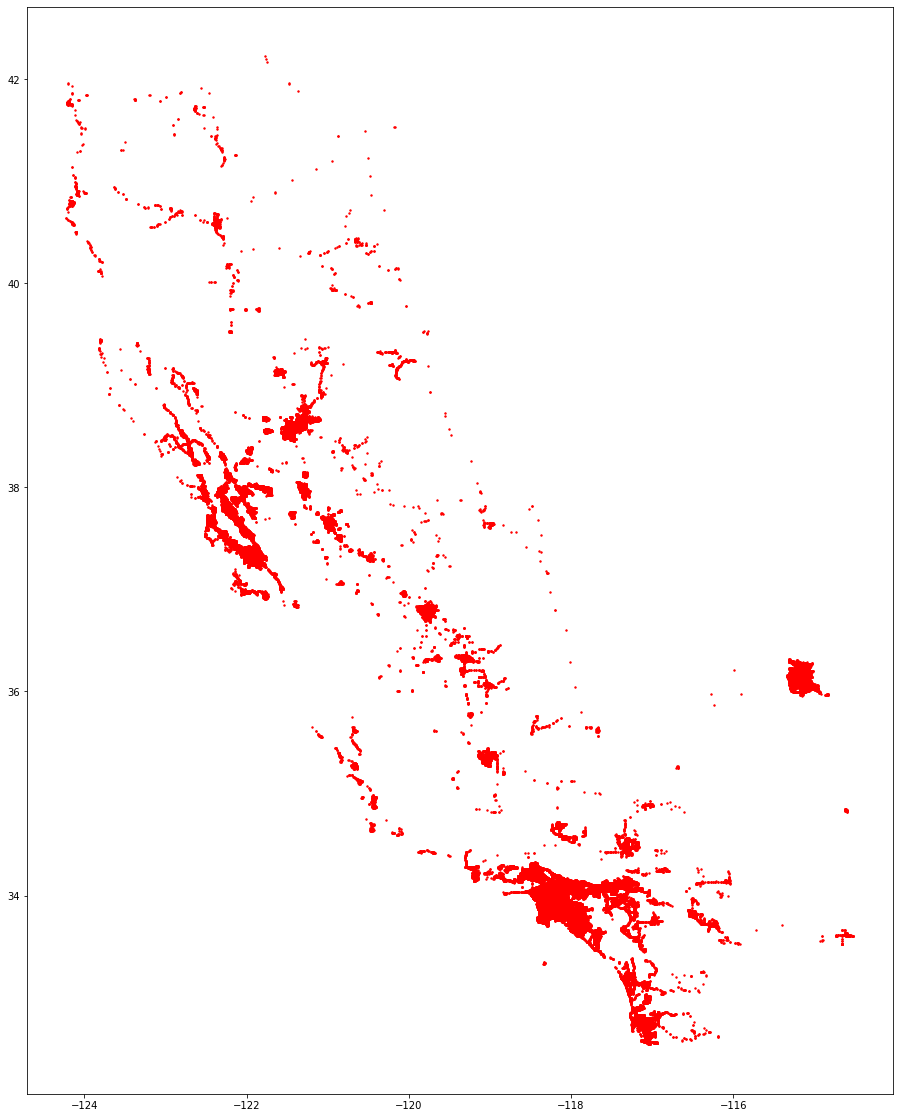

In [13]:
gdf.plot(figsize=(25,20), color='red', markersize=2)

# Read City of LA Boundary

<AxesSubplot:>

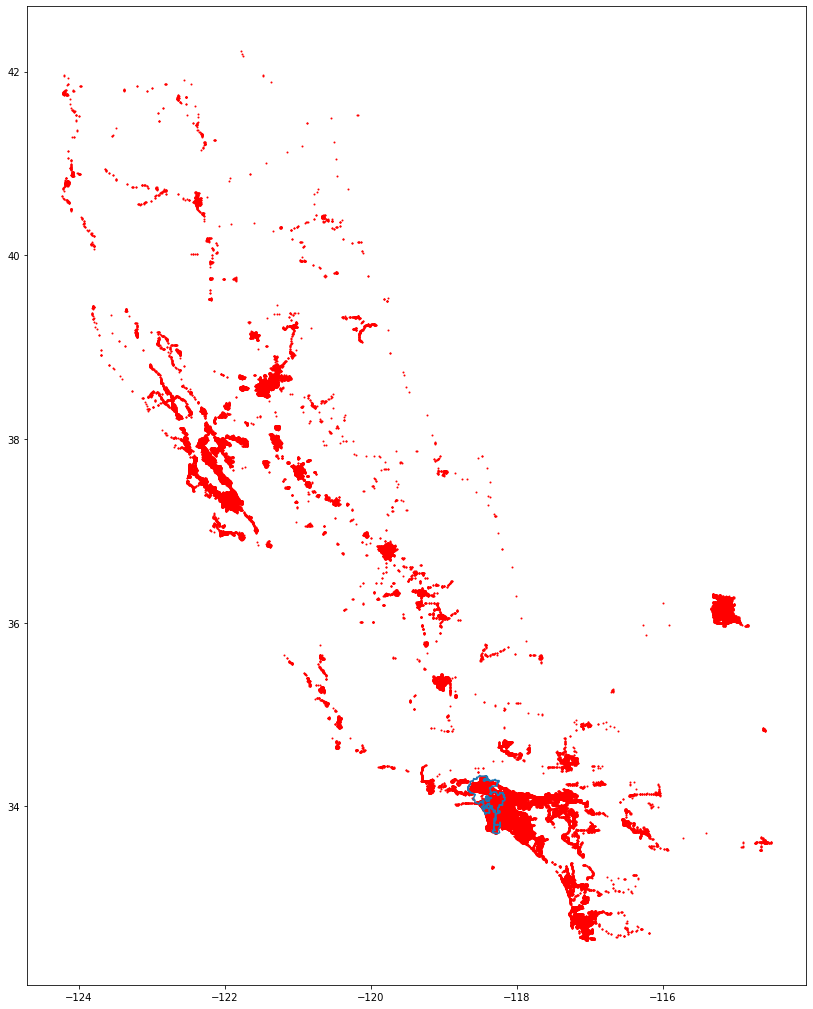

In [14]:
la_city = gpd.read_file('City_Boundary.shp', figsize=(20,17))
ax = la_city.boundary.plot(figsize=(20,18))
gdf.plot(ax=ax, color='red', markersize=1)

In [16]:
import shapely.speedups
shapely.speedups.enable() 

# enable shapely.speedups which makes queries running faster.
pip_mask = gdf.within(la_city.loc[0, 'geometry']) 
# selecting the polygon's geometry field to filter out points that 
# are not overlaid
la_bus_stops = gdf.loc[pip_mask]

In [99]:
cpa = gpd.read_file('Community_Plan_Areas_(CPA).shp')
cpa

OBJECTID  CPA_NUM                                           NAME_ALF  \
0          1     4350                                     Harbor Gateway   
1          2     3280                        Palms - Mar Vista - Del Rey   
2          3     3320                            Bel Air - Beverly Crest   
3          4     2190                          Granada Hills - Knollwood   
4          5     2160        Mission Hills - Panorama City - North Hills   
5          6     2240                                   Encino - Tarzana   
6          7     3310                      Brentwood - Pacific Palisades   
7          8     1040               West Adams - Baldwin Hills - Leimert   
8          9     2130                   North Hollywood - Valley Village   
9         10     2140                                   Arleta - Pacoima   
10        11     1010                              Northeast Los Angeles   
11        12     3290                                             Venice   
12        13     1080           Silver Lake - Echo Park - Elysian Valley   
13        14     4340                                          San Pedro   
14        15     2230                             Reseda - West Van Nuys   
15        16     2170                        Sun Valley - La Tuna Canyon   
16        17     2250  Sunland - Tujunga - Lake View Terrace - Shadow...   
17        18     3260                                           Westwood   
18        19     3270                                   West Los Angeles   
19        20     1070                                          Hollywood   
20        21     2200  Canoga Park - Winnetka - Woodland Hills - West...   
21        22     1110                                 Central City North   
22        23     2210                          Chatsworth - Porter Ranch   
23        24     4430                           Wilmington - Harbor City   
24        25     2180                                             Sylmar   
25        26     1060                                           Wilshire   
26        27     1100                                       Central City   
27        28     1090                                           Westlake   
28        29     4360                                Port of Los Angeles   
29        30     2220                                         Northridge   
30        31     2150                      Van Nuys - North Sherman Oaks   
31        32     1020                                      Boyle Heights   
32        33     2120  Sherman Oaks - Studio City - Toluca Lake - Cah...   
33        34     3300                        Westchester - Playa del Rey   
34        35     3700                  Los Angeles International Airport   
35        36     1050                                  South Los Angeles   
36        37     1030                              Southeast Los Angeles   

      Shape__Are     Shape__Len  \
0   1.412080e+08  114251.577211   
1   2.292019e+08  133049.457264   
2   4.217724e+08  133941.056641   
3   4.519270e+08   95424.789014   
4   3.294878e+08  105646.096422   
5   5.657898e+08  111443.207921   
6   1.060862e+09  167625.599939   
7   3.577806e+08  140607.999552   
8   2.957979e+08   79832.693668   
9   2.883400e+08   83982.590488   
10  6.829526e+08  167982.026716   
11  8.735921e+07   56849.164097   
12  1.983005e+08   68555.021453   
13  2.077602e+08  124888.907169   
14  3.387916e+08   86655.720770   
15  4.577544e+08  119818.236140   
16  7.139124e+08  195928.647891   
17  1.027200e+08   50561.874462   
18  1.993244e+08   81851.780889   
19  6.995995e+08  176559.087251   
20  7.801287e+08  140177.581615   
21  8.809307e+07   60051.085041   
22  6.769280e+08  137490.109196   
23  2.838327e+08  122828.398375   
24  3.435697e+08  112996.120777   
25  3.903689e+08  107857.360135   
26  9.723583e+07   40802.203172   
27  8.463491e+07   40577.514531   
28  3.117367e+08  132590.670811   
29  2.759991e+08   77587.977213   
30  3.585585e+08   86256.89929

<AxesSubplot:>

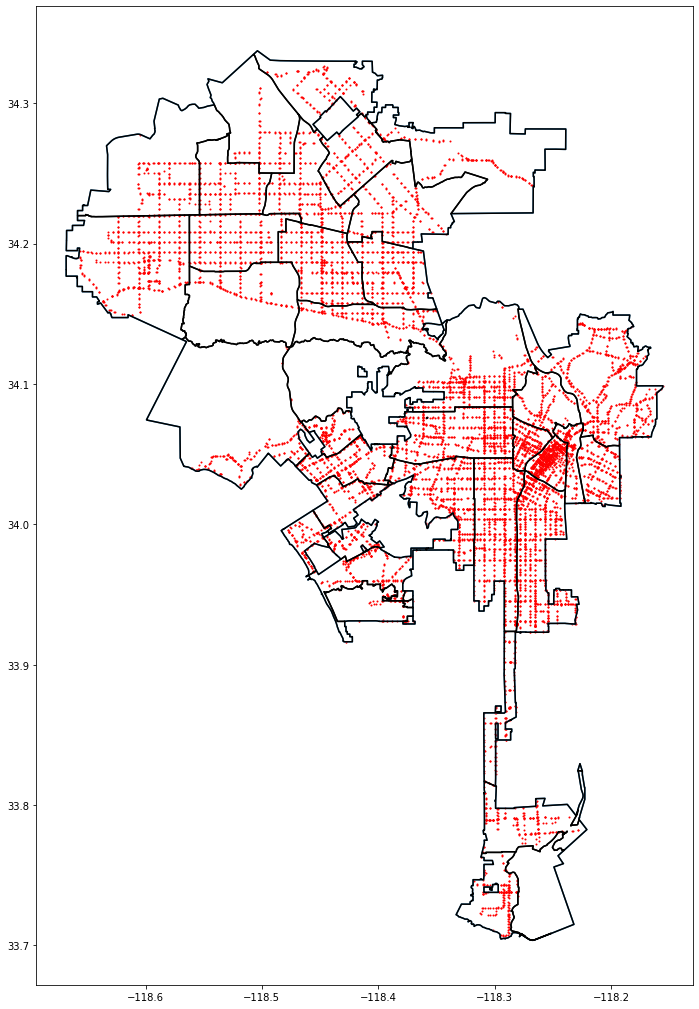

In [100]:
ax = la_city.boundary.plot(figsize=(20,18))
cpa.boundary.plot(ax=ax, color='black')
la_bus_stops.plot(ax=ax, color='red', markersize=1)

In [105]:
cpa.columns

Index(['OBJECTID', 'CPA_NUM', 'NAME_ALF', 'Shape__Are', 'Shape__Len',
       'geometry'],
      dtype='object')

In [106]:
cpa['coords'] = cpa['geometry'].apply(lambda x: x.representative_point().coords[:])
cpa['coords'] = [coords[0] for coords in cpa['coords']]

In [210]:
list(cpa['NAME_ALF'].unique())

['Harbor Gateway',
 'Palms - Mar Vista - Del Rey',
 'Bel Air - Beverly Crest',
 'Granada Hills - Knollwood',
 'Mission Hills - Panorama City - North Hills',
 'Encino - Tarzana',
 'Brentwood - Pacific Palisades',
 'West Adams - Baldwin Hills - Leimert',
 'North Hollywood - Valley Village',
 'Arleta - Pacoima',
 'Northeast Los Angeles',
 'Venice',
 'Silver Lake - Echo Park - Elysian Valley',
 'San Pedro',
 'Reseda - West Van Nuys',
 'Sun Valley - La Tuna Canyon',
 'Sunland - Tujunga - Lake View Terrace - Shadow Hills - East La Tuna Canyon',
 'Westwood',
 'West Los Angeles',
 'Hollywood',
 'Winnetka - Woodland Hills - West Hills',
 'Central City North',
 'Chatsworth - Porter Ranch',
 'Wilmington - Harbor City',
 'Sylmar',
 'Wilshire',
 'Central City',
 'Westlake',
 'Port of Los Angeles',
 'Northridge',
 'Van Nuys - North Sherman Oaks',
 'Boyle Heights',
 'Sherman Oaks - Studio City - Toluca Lake - Cahuenga Pass',
 'Westchester - Playa del Rey',
 'Los Angeles International Airport',
 'Sout

In [211]:
cpa['NAME_ALF']
cpa['NAME_ALF'] = cpa['NAME_ALF'].replace('Canoga Park - Winnetka - Woodland Hills - West Hills',
                                          'Winnetka - Woodland Hills - West Hills')
cpa['NAME_ALF'] = cpa['NAME_ALF'].replace('Sunland - Tujunga - Lake View Terrace - Shadow Hills - East La Tuna Canyon',
                                          'Sunland - Tujunga - Lake View Terrace - Shadow Hills')

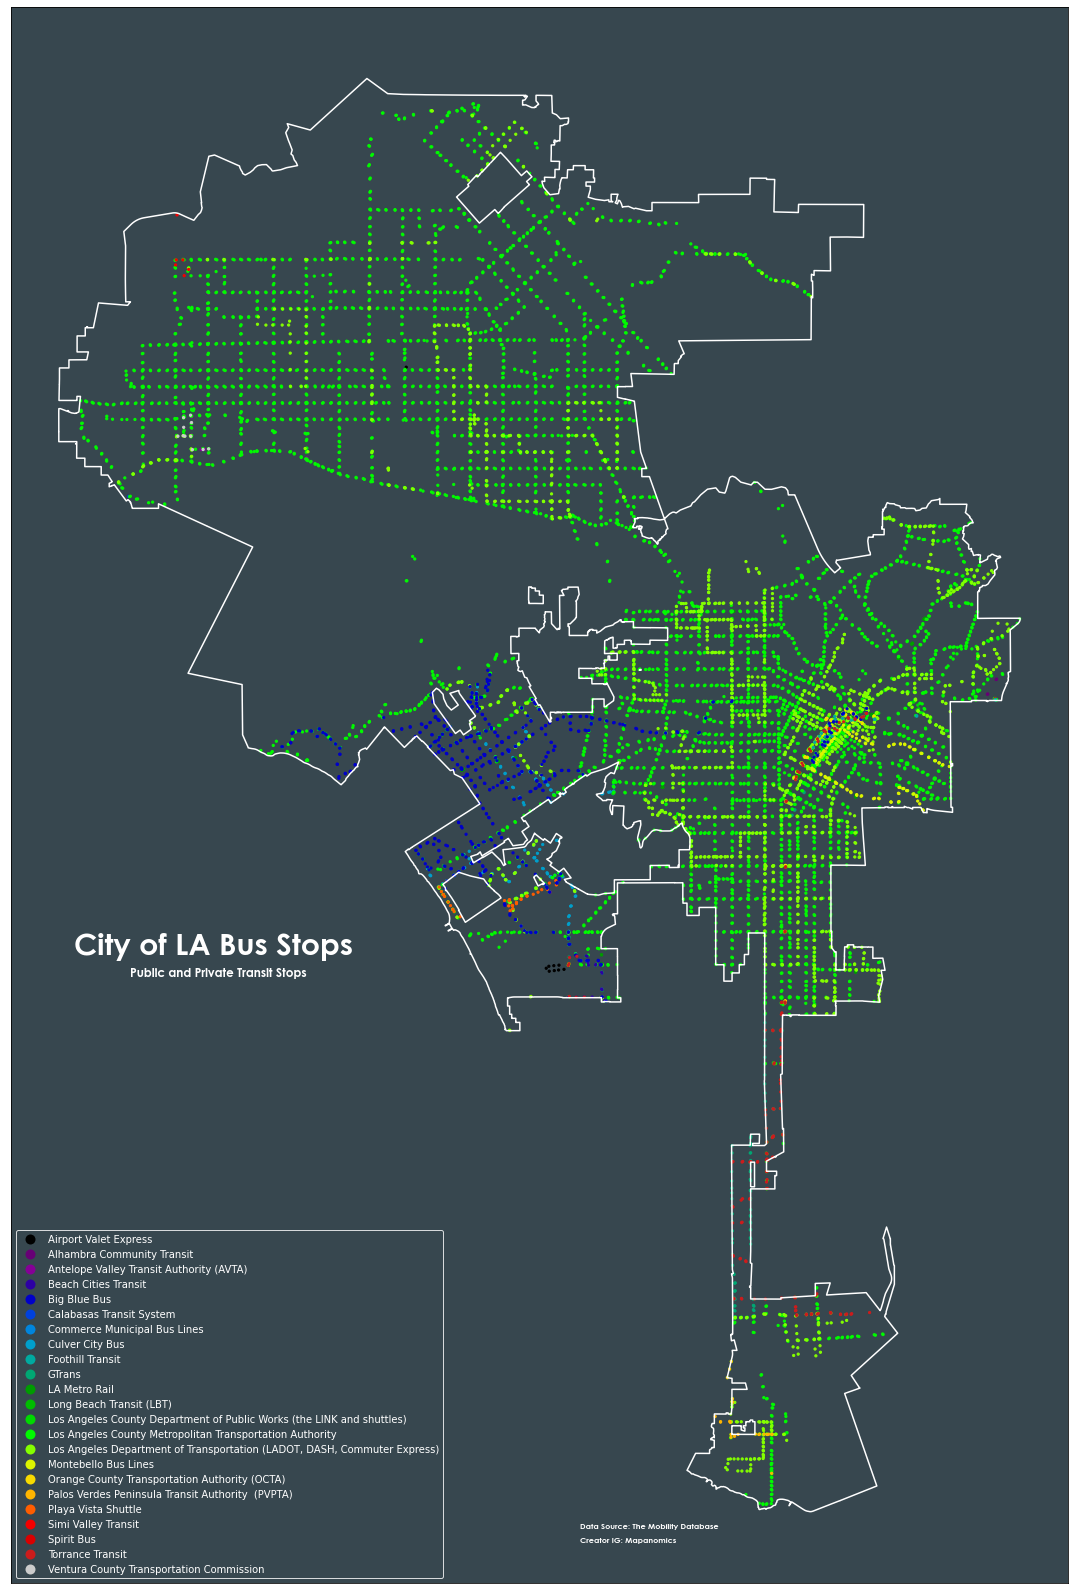

In [140]:
leg_args = {'loc':'best', 
            'labelcolor':'white',
            'edgecolor':'white',
            'facecolor':'#37474F',
            'fontsize':'medium',
            'prop': {'size': 10}}

ax = la_city.boundary.plot(figsize=(22,29), color='white')
#ax= cpa.boundary.plot(figsize=(22,25), color='white')
ax.annotate('City of LA Bus Stops',xy=(-118.66, 33.95), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=30,fontweight='bold')
ax.annotate('Public and Private Transit Stops',xy=(-118.63, 33.94), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=12,fontweight='bold')
ax.annotate('Creator IG: Mapanomics',xy=(-118.39, 33.69), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=8,fontweight='bold')
ax.annotate('Data Source: The Mobility Database',xy=(-118.39, 33.696), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=8,fontweight='bold')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# texts =[ax.text(row.coords[0], row.coords[1], 
  #              fontstyle="italic",fontsize=12, fontweight='bold',color='white', 
  #              s=row["NAME_ALF"], horizontalalignment='center',
   #             path_effects=[pe.withStroke(linewidth=1.8, foreground="black")]) for idx, row in cpa.iterrows()]

# adjust_text(texts)

la_bus_stops.plot(ax=ax, column='Agency_Transit', markersize=5, legend=True,cmap='nipy_spectral',legend_kwds=leg_args)
ax.set_facecolor('#37474F')
plt.savefig(f'LA City Bus Stops.png',dpi=250)


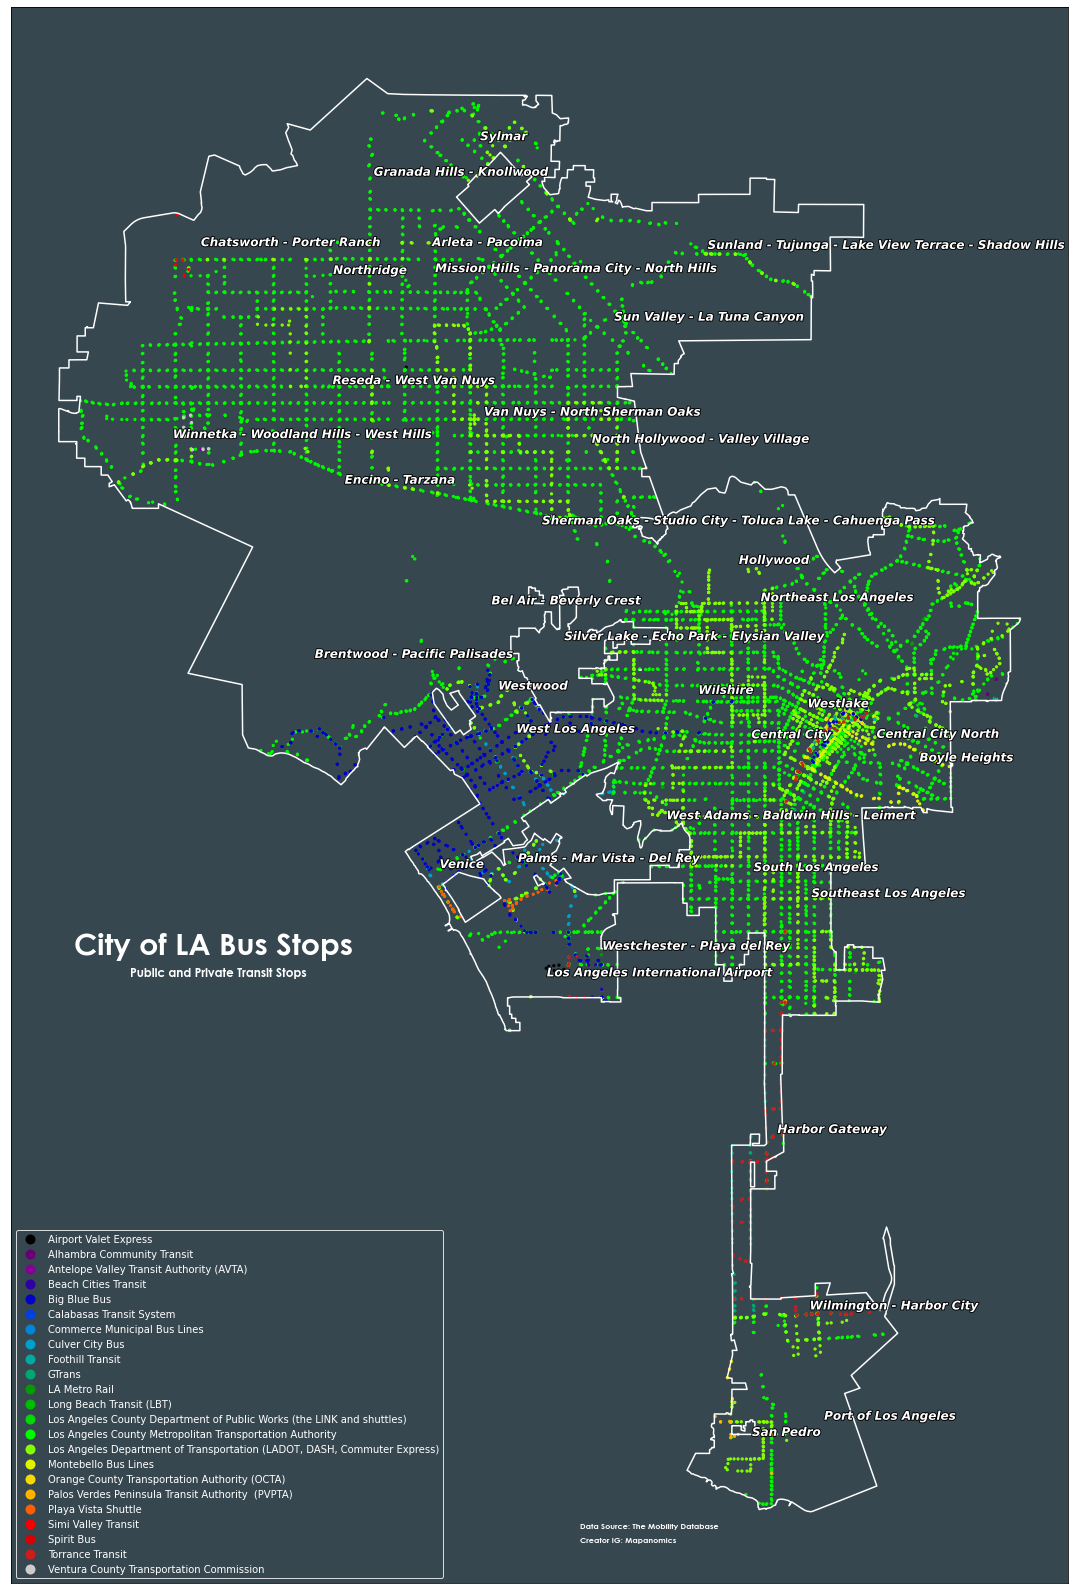

In [213]:
leg_args = {'loc':'best', 
            'labelcolor':'white',
            'edgecolor':'white',
            'facecolor':'#37474F',
            'fontsize':'medium',
            'prop': {'size': 10}}

ax = la_city.boundary.plot(figsize=(22,29), color='white')
#ax= cpa.boundary.plot(figsize=(22,25), color='white')
ax.annotate('City of LA Bus Stops',xy=(-118.66, 33.95), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=30,fontweight='bold')
ax.annotate('Public and Private Transit Stops',xy=(-118.63, 33.94), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=12,fontweight='bold')
ax.annotate('Creator IG: Mapanomics',xy=(-118.39, 33.69), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=8,fontweight='bold')
ax.annotate('Data Source: The Mobility Database',xy=(-118.39, 33.696), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=8,fontweight='bold')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

texts =[ax.text(row.coords[0], row.coords[1], 
                fontstyle="italic",fontsize=12, fontweight='bold',color='white', 
                s=row["NAME_ALF"], horizontalalignment='center',
                path_effects=[pe.withStroke(linewidth=1.8, foreground="black")]) for idx, row in cpa.iterrows()]

adjust_text(texts)

la_bus_stops.plot(ax=ax, column='Agency_Transit', markersize=5, legend=True,cmap='nipy_spectral',legend_kwds=leg_args) 
ax.set_facecolor('#37474F')
plt.savefig(f'LA City Bus Stops with Labels.jpeg',dpi=250)


C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\sit

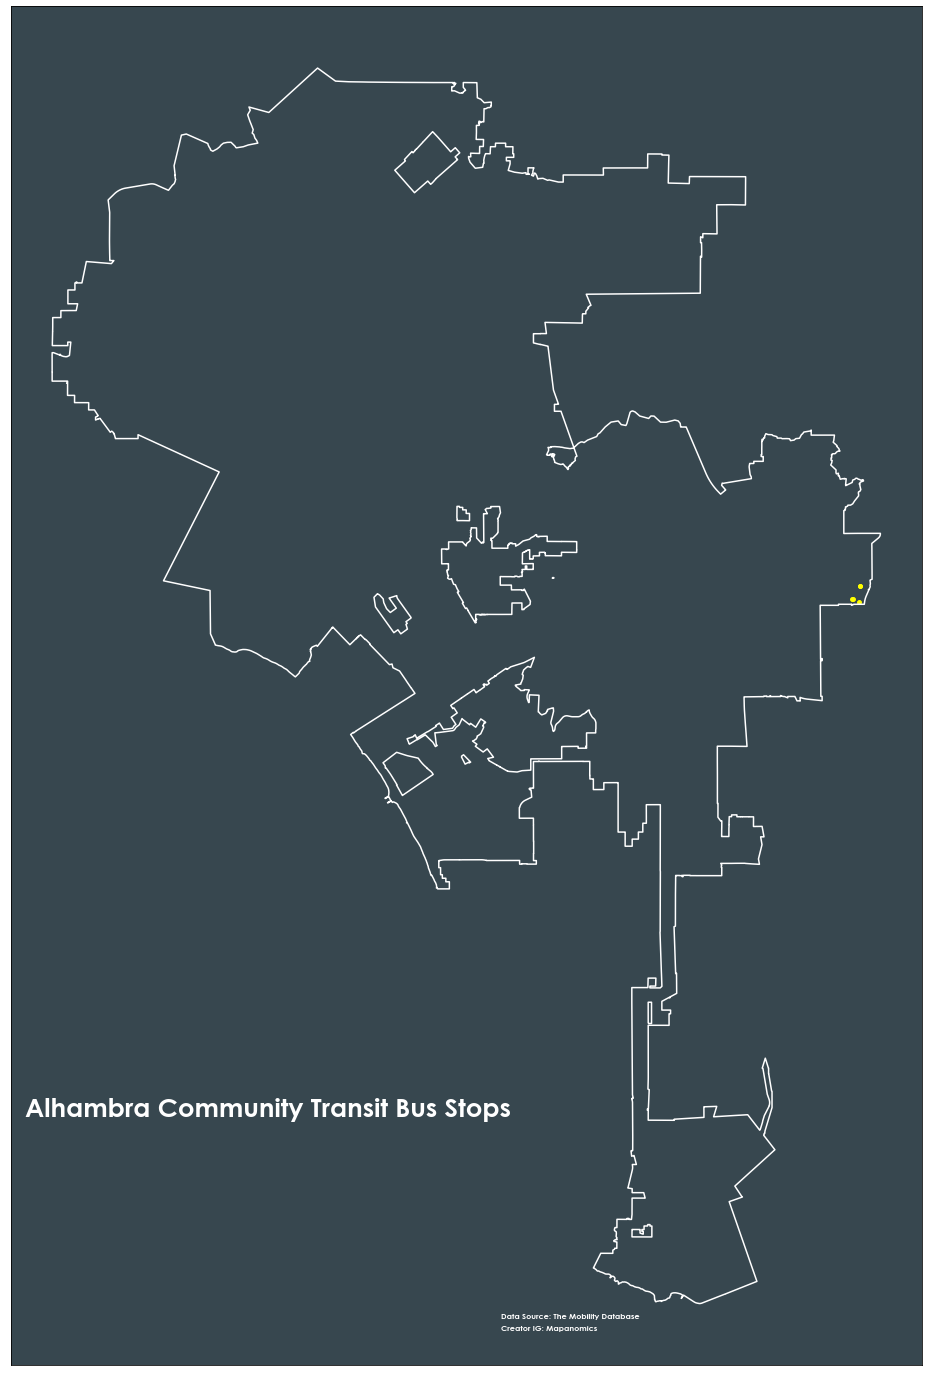

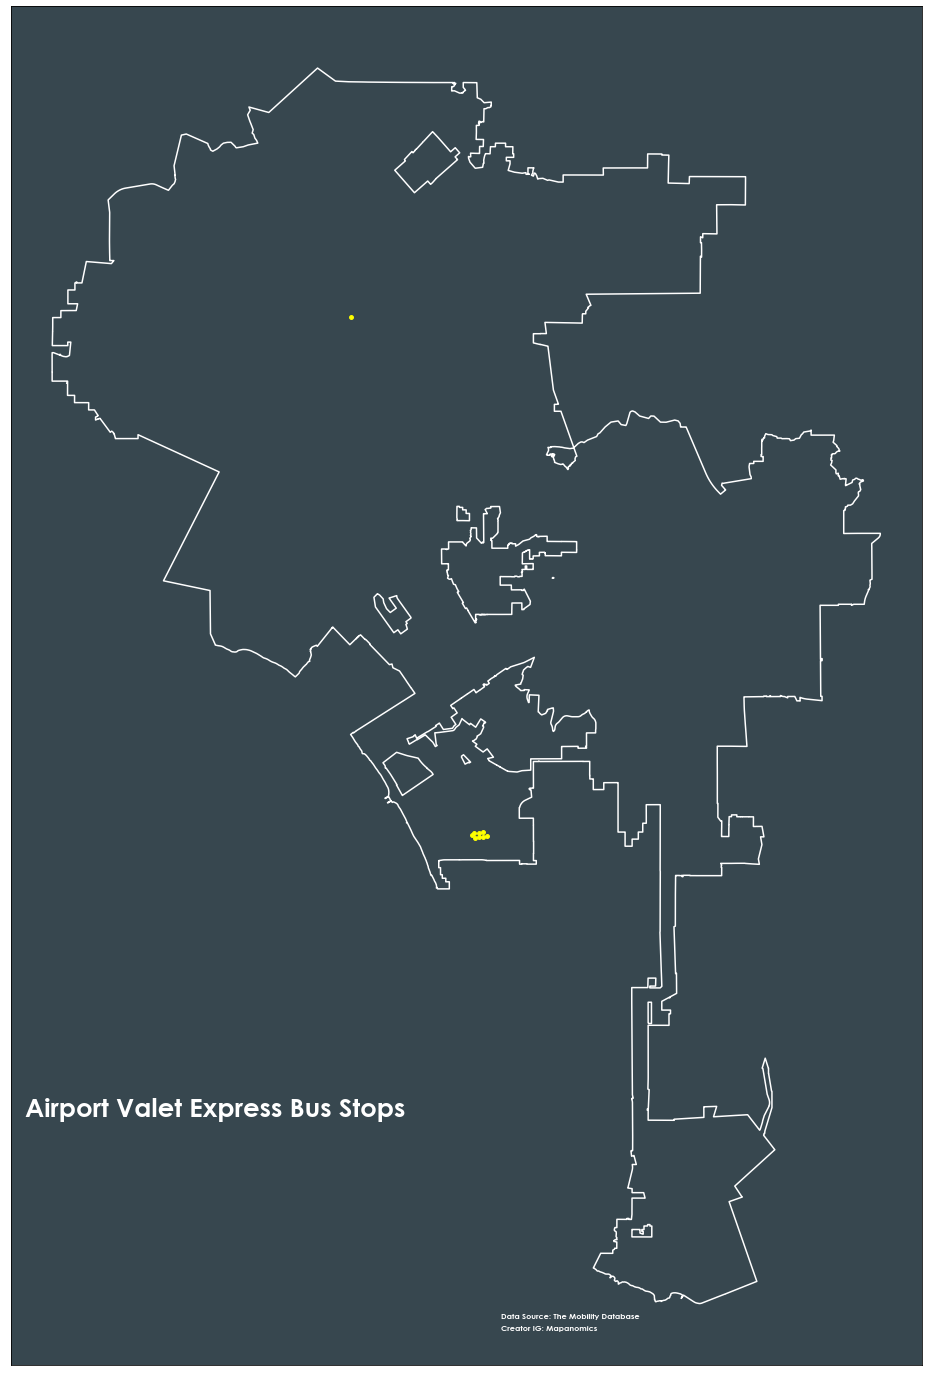

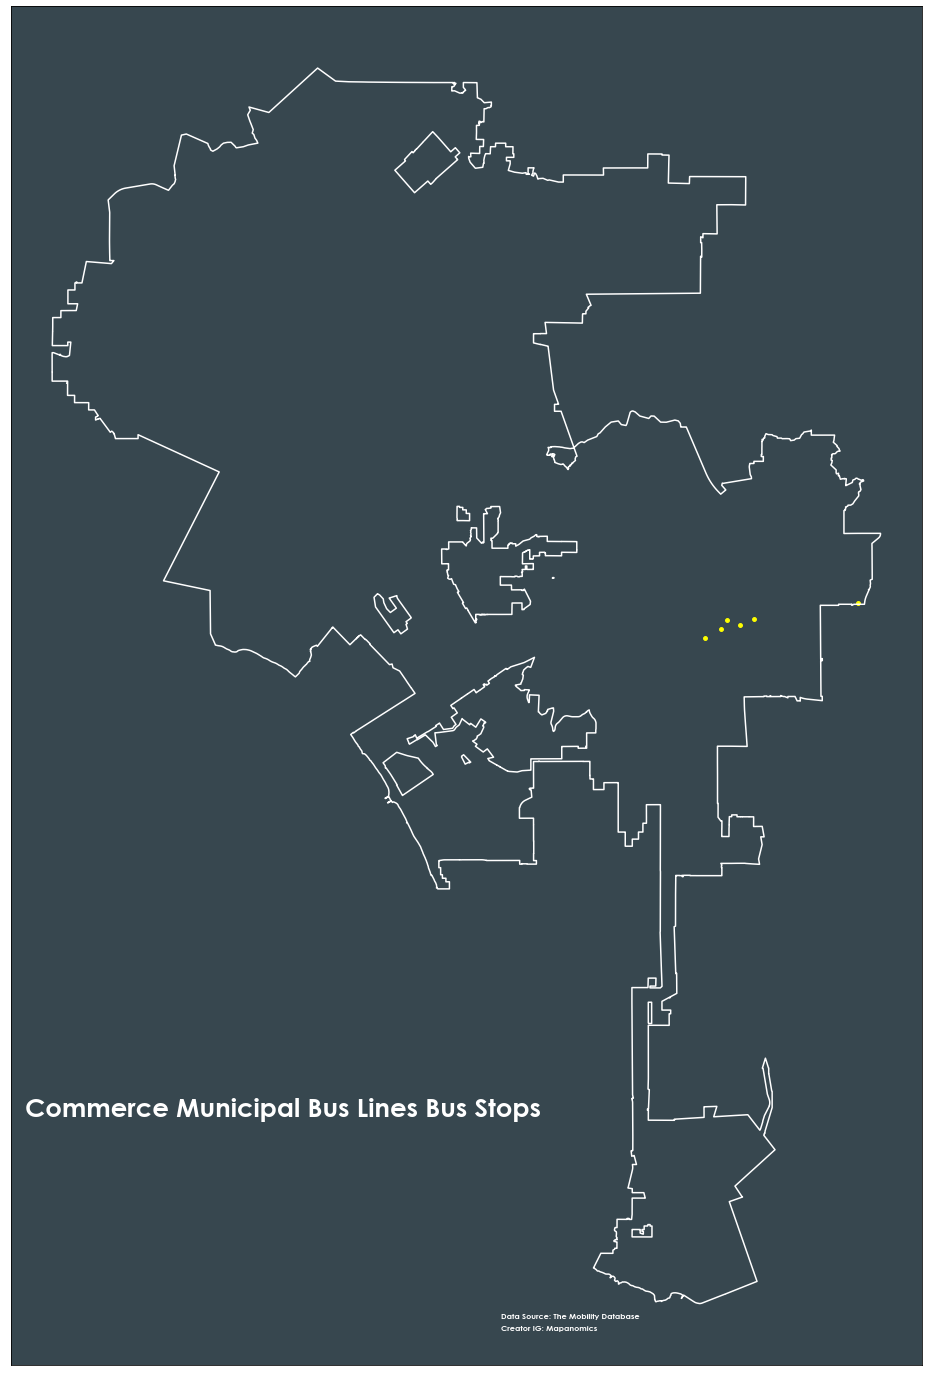

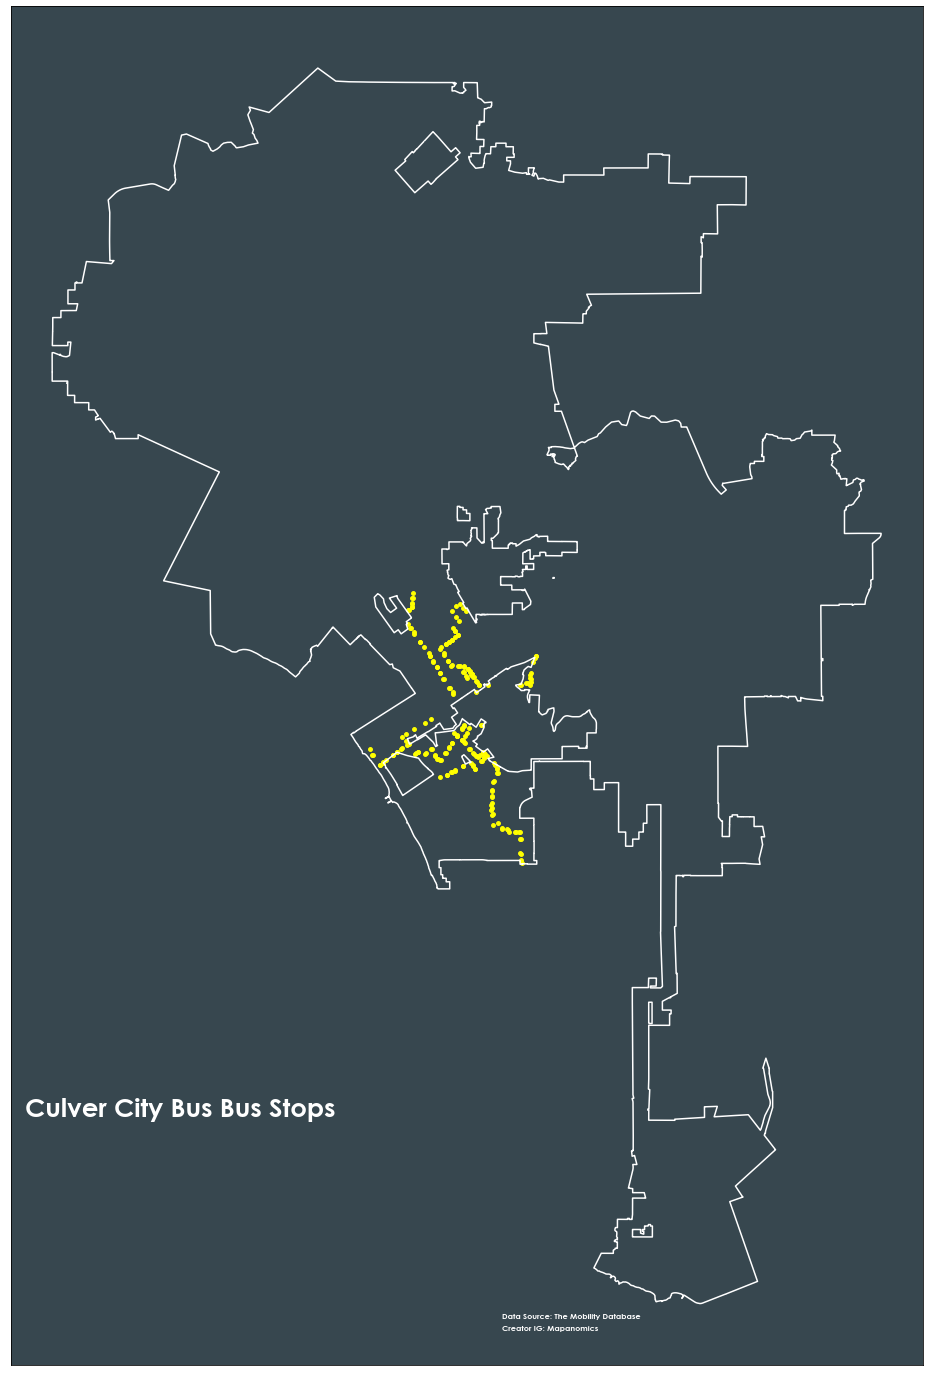

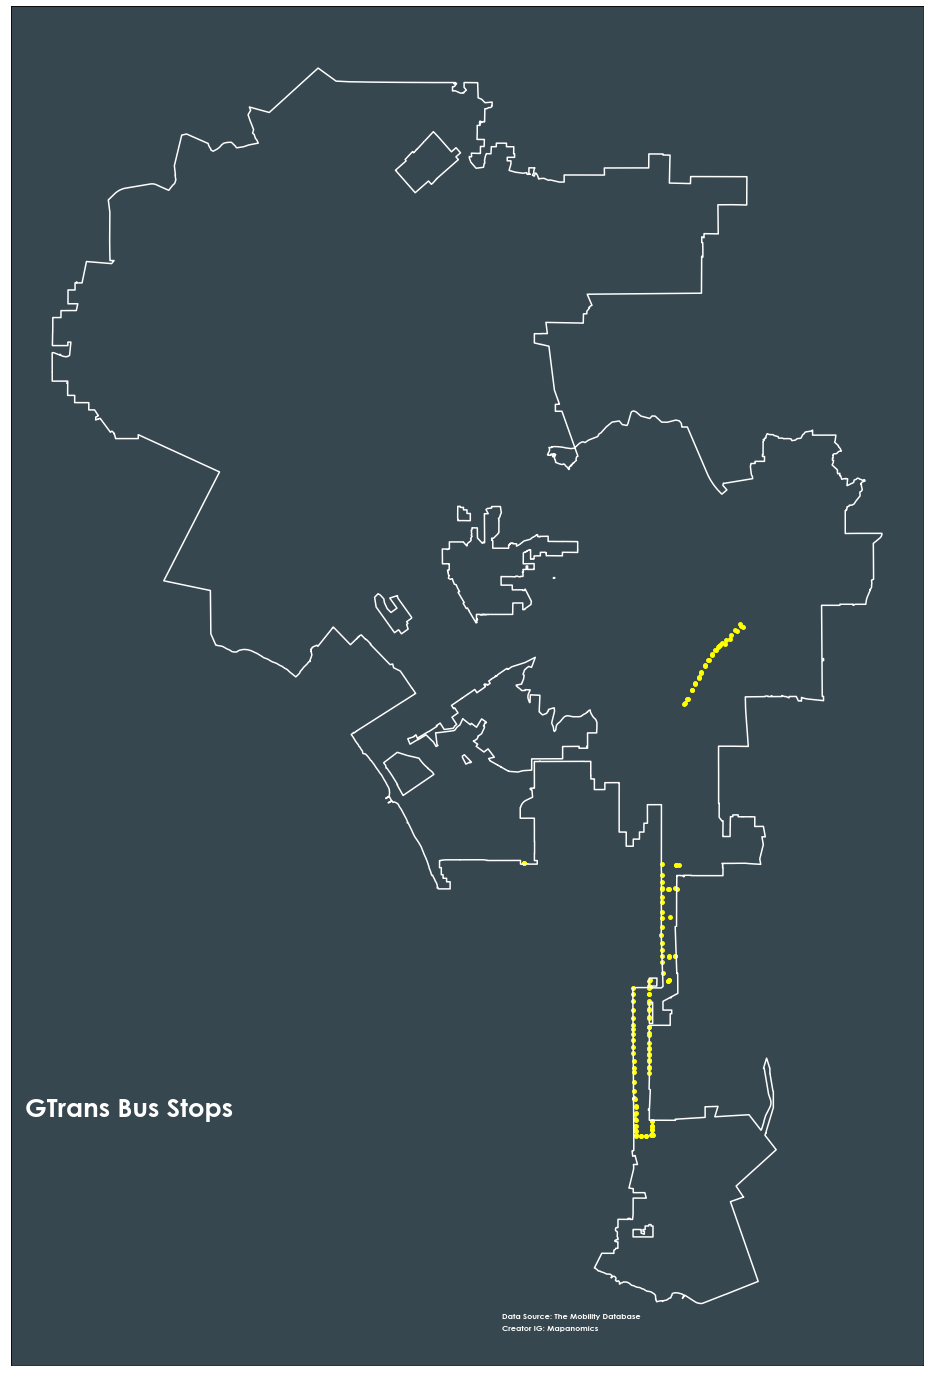

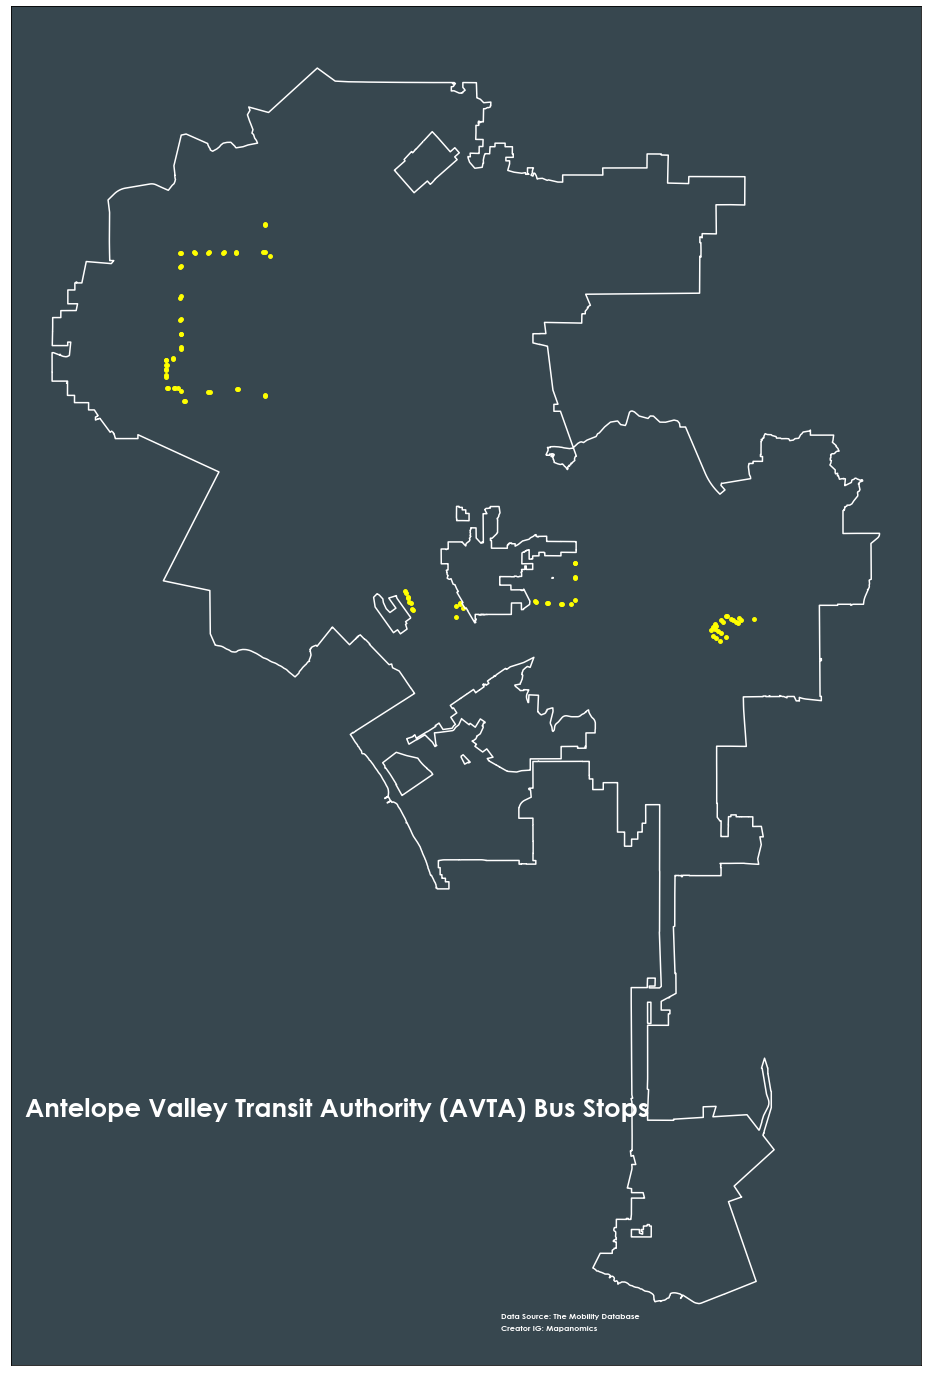

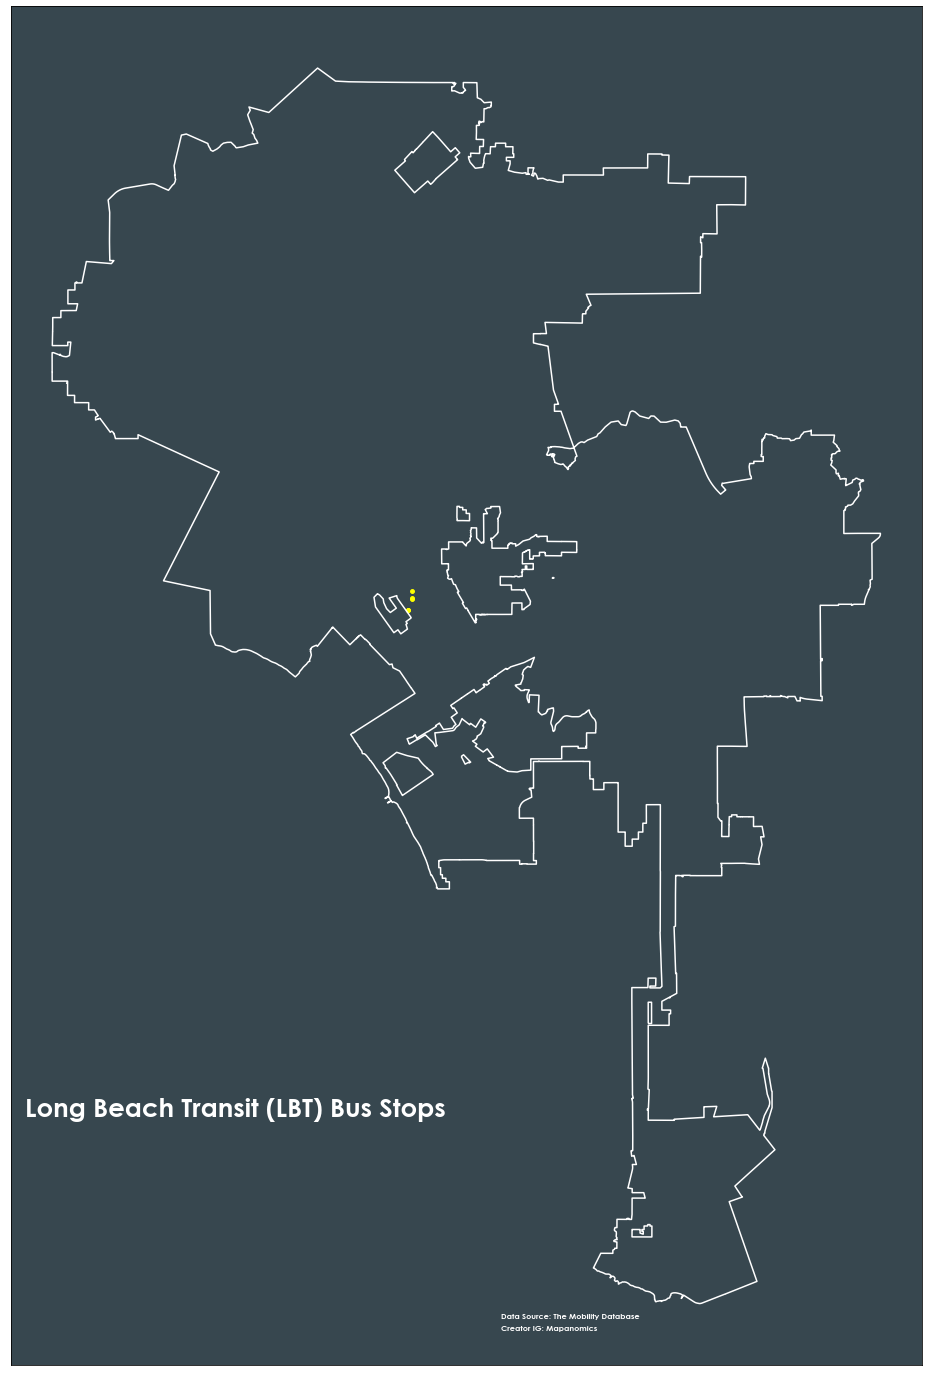

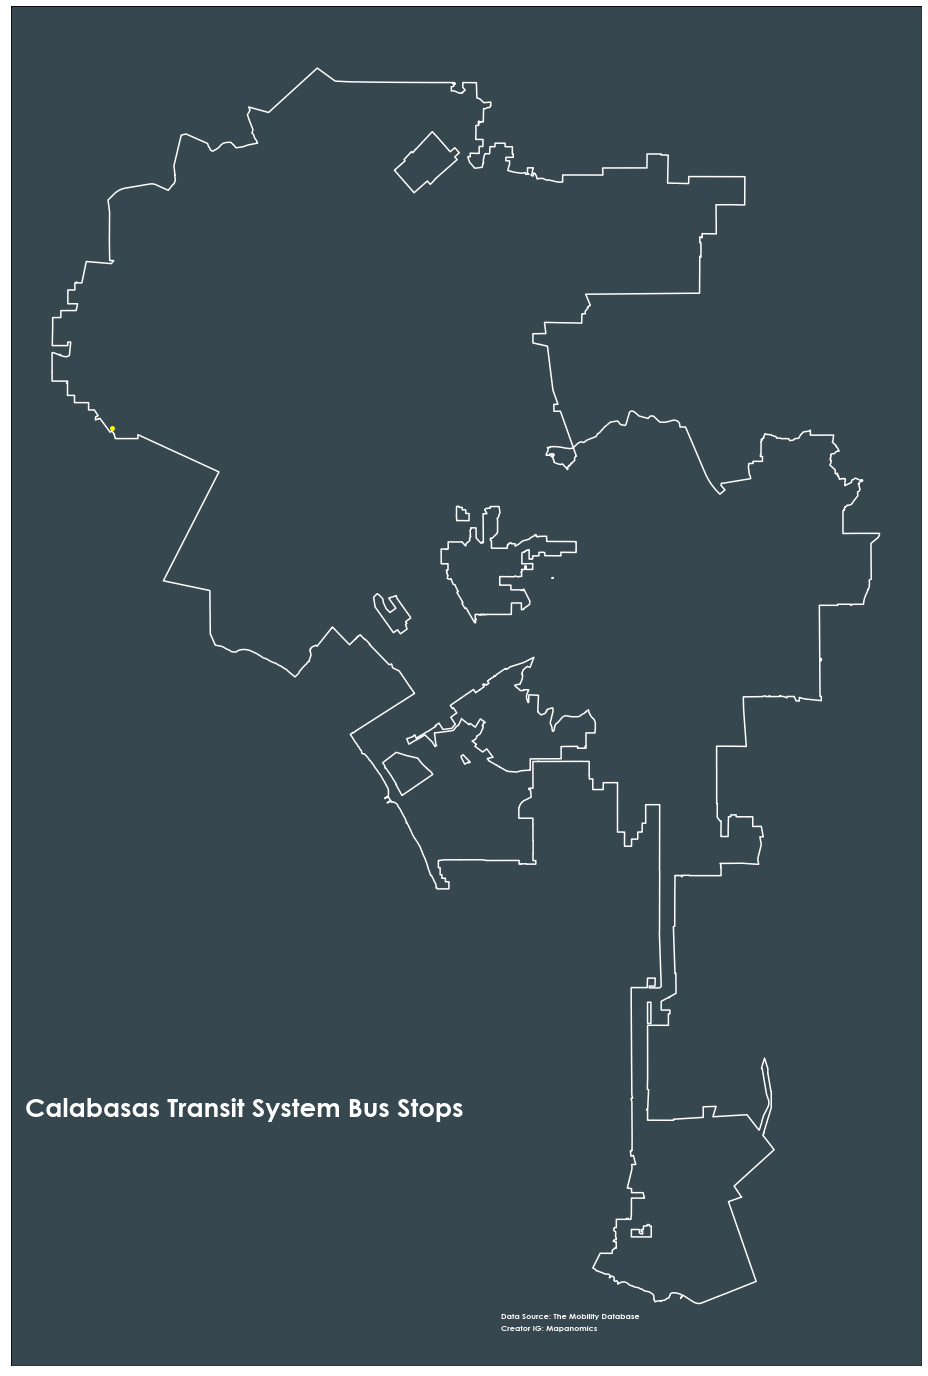

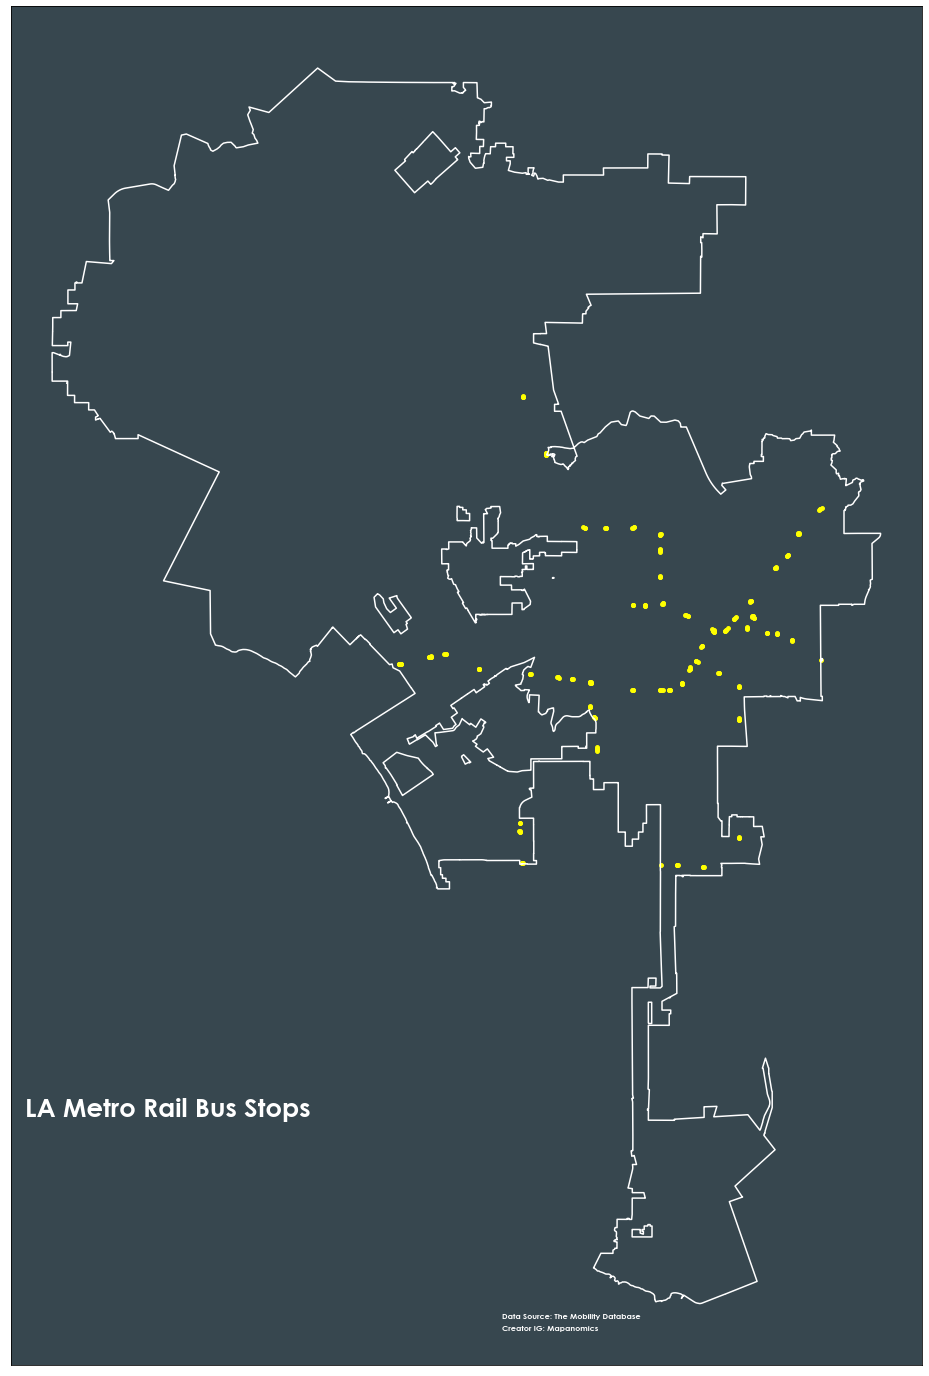

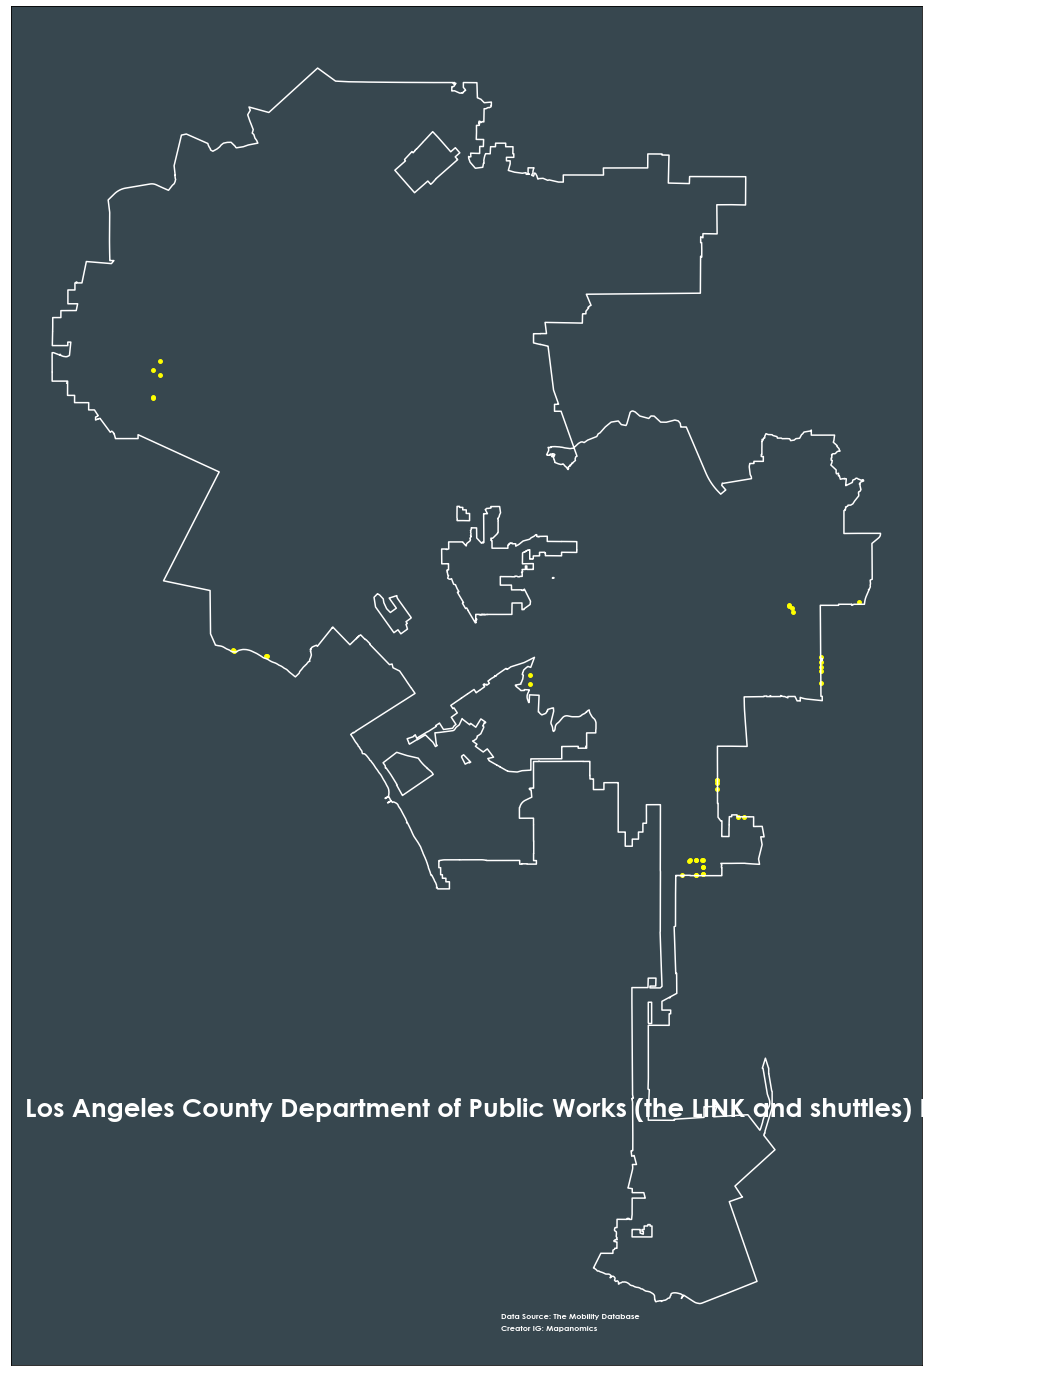

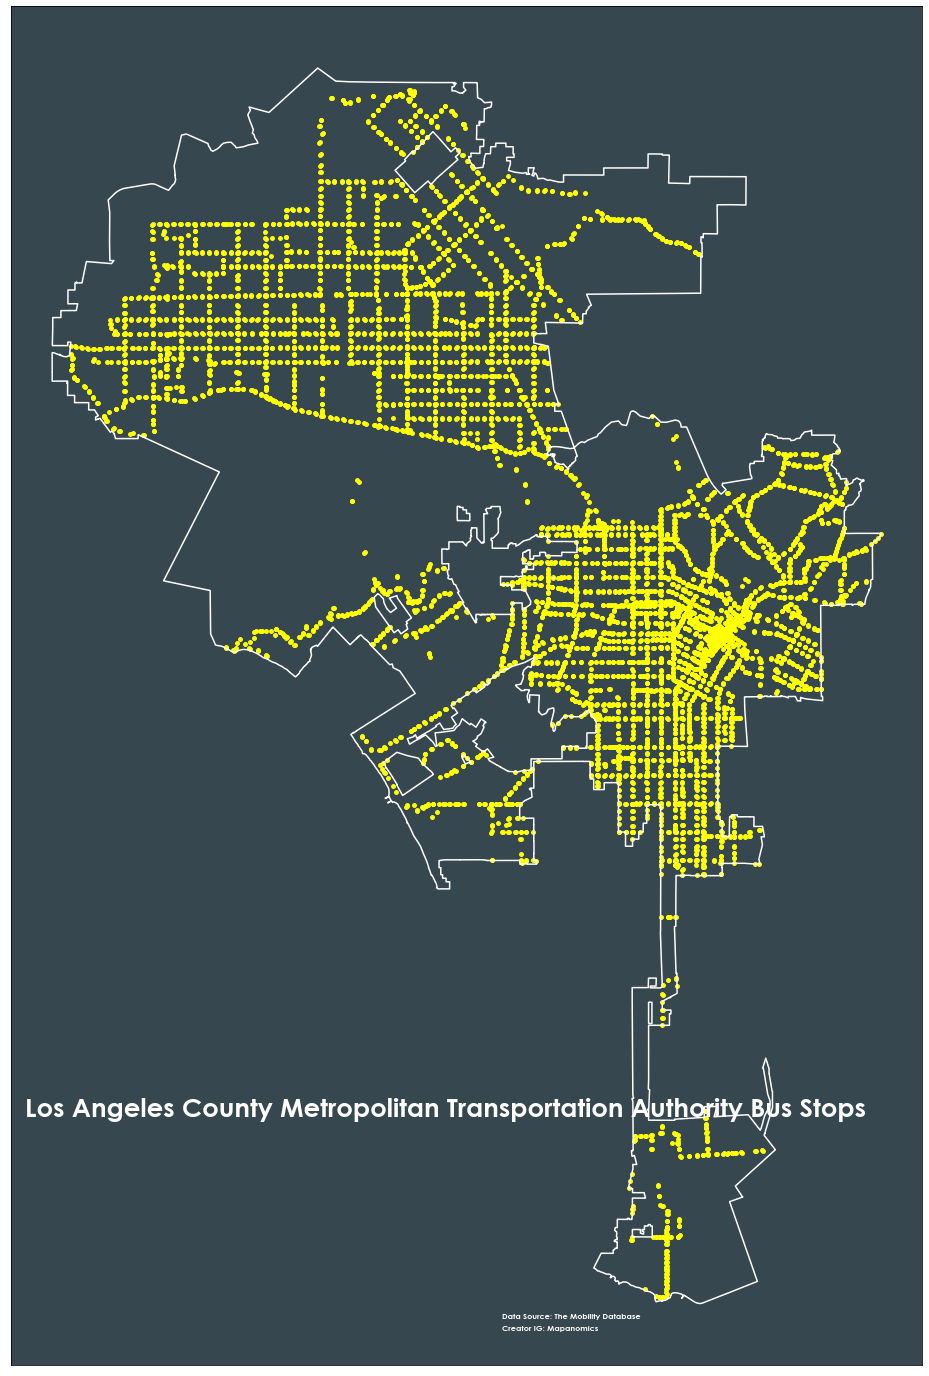

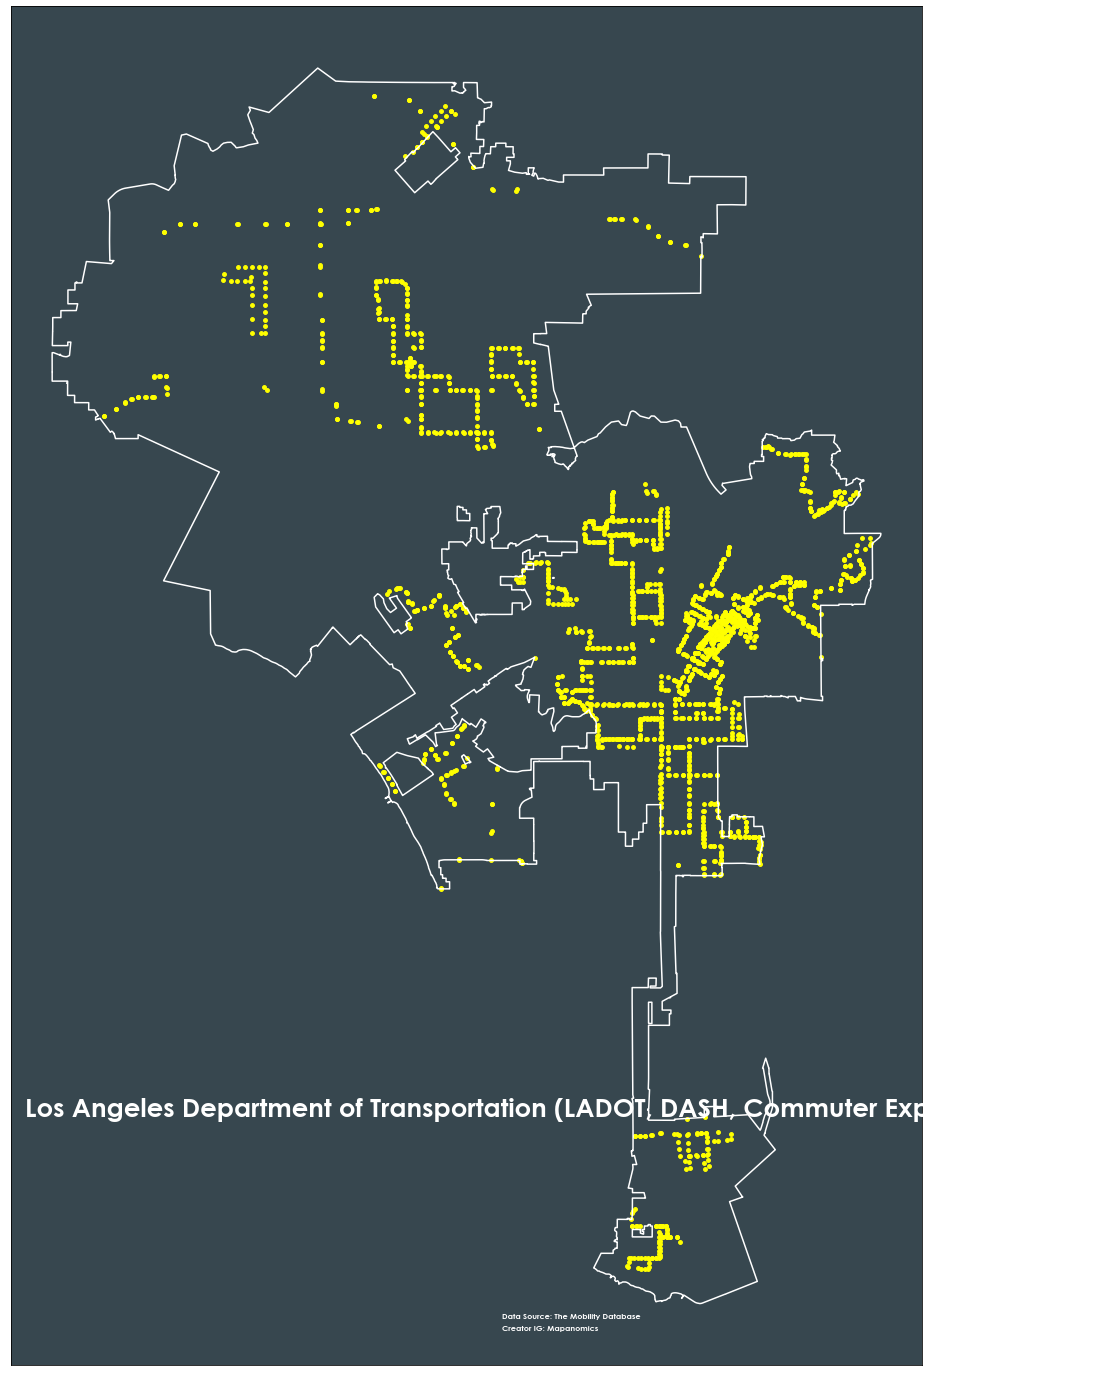

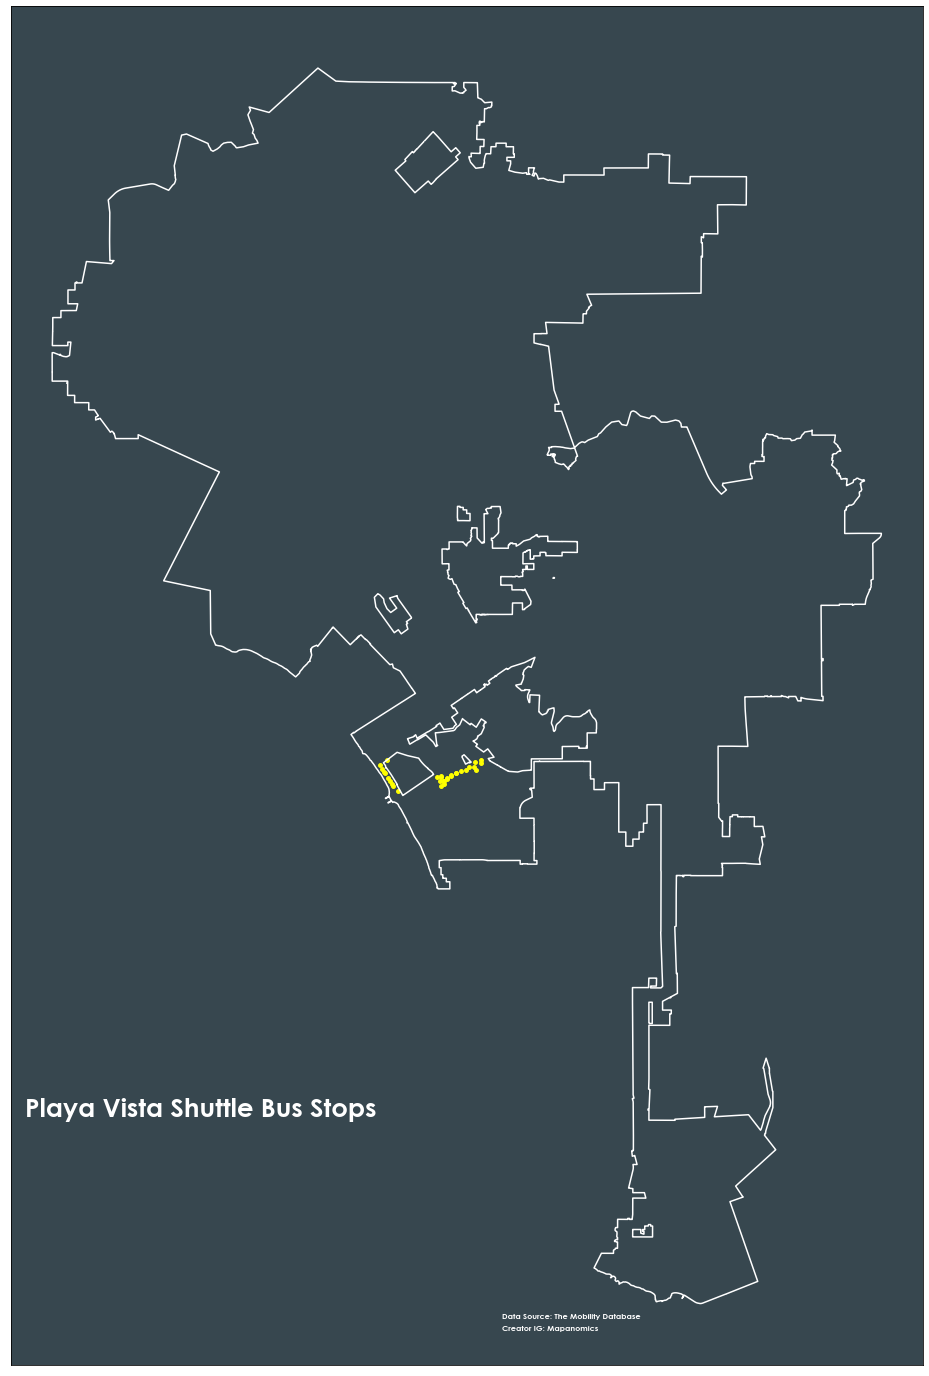

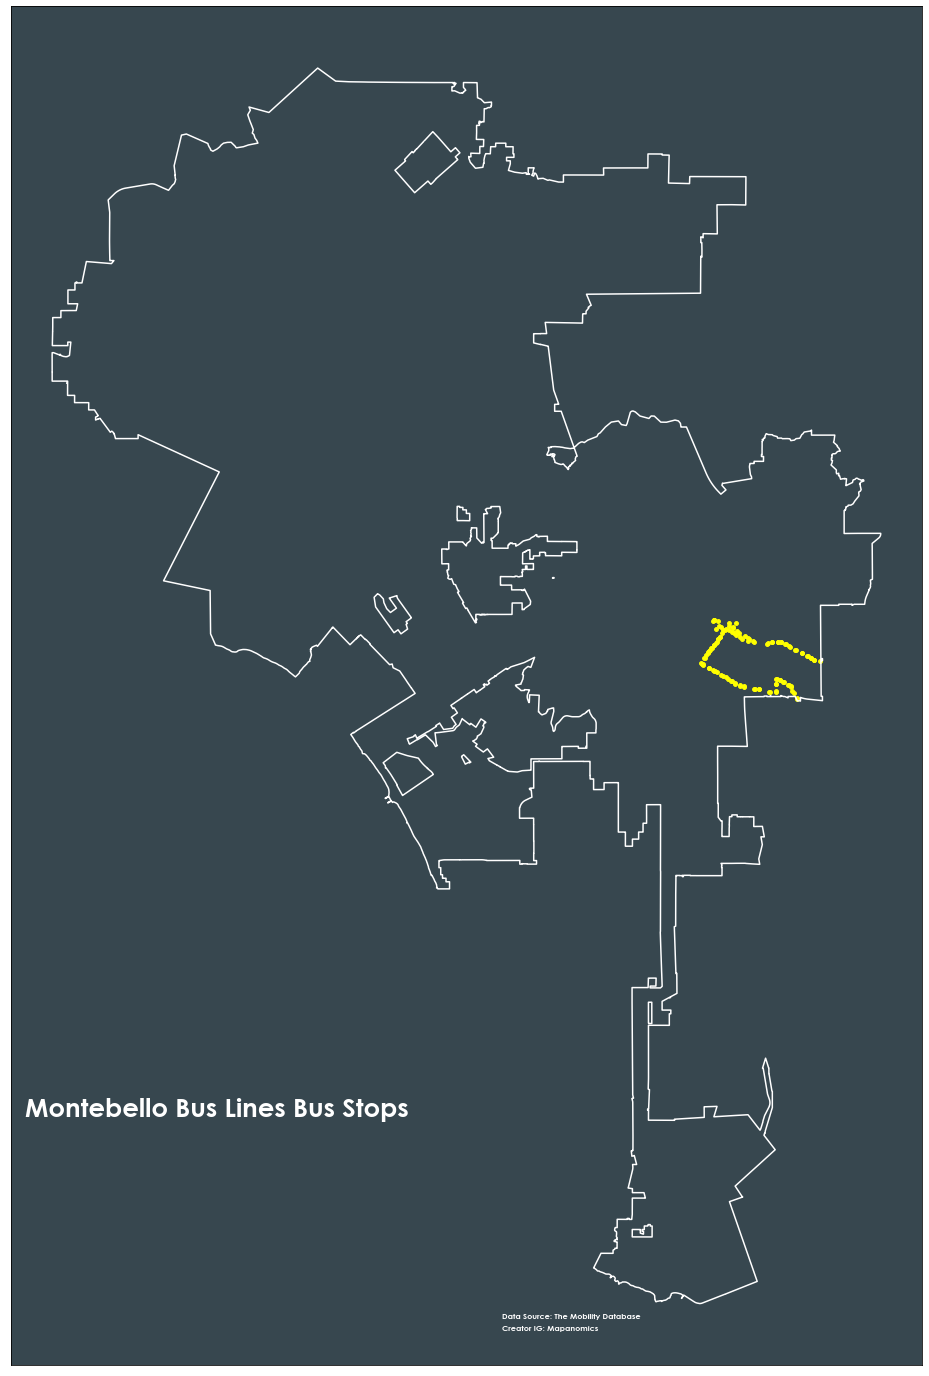

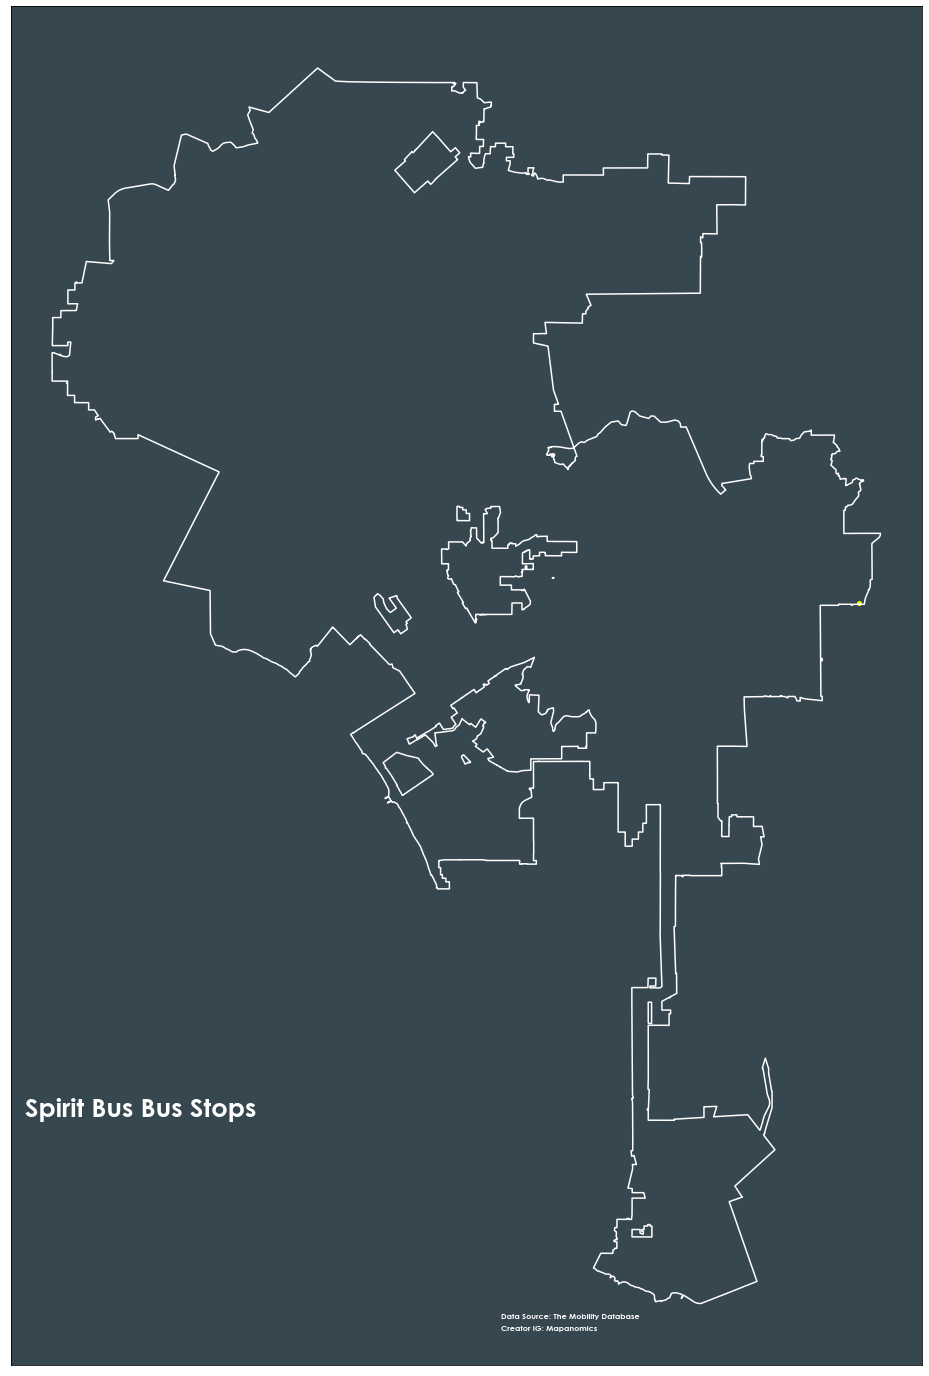

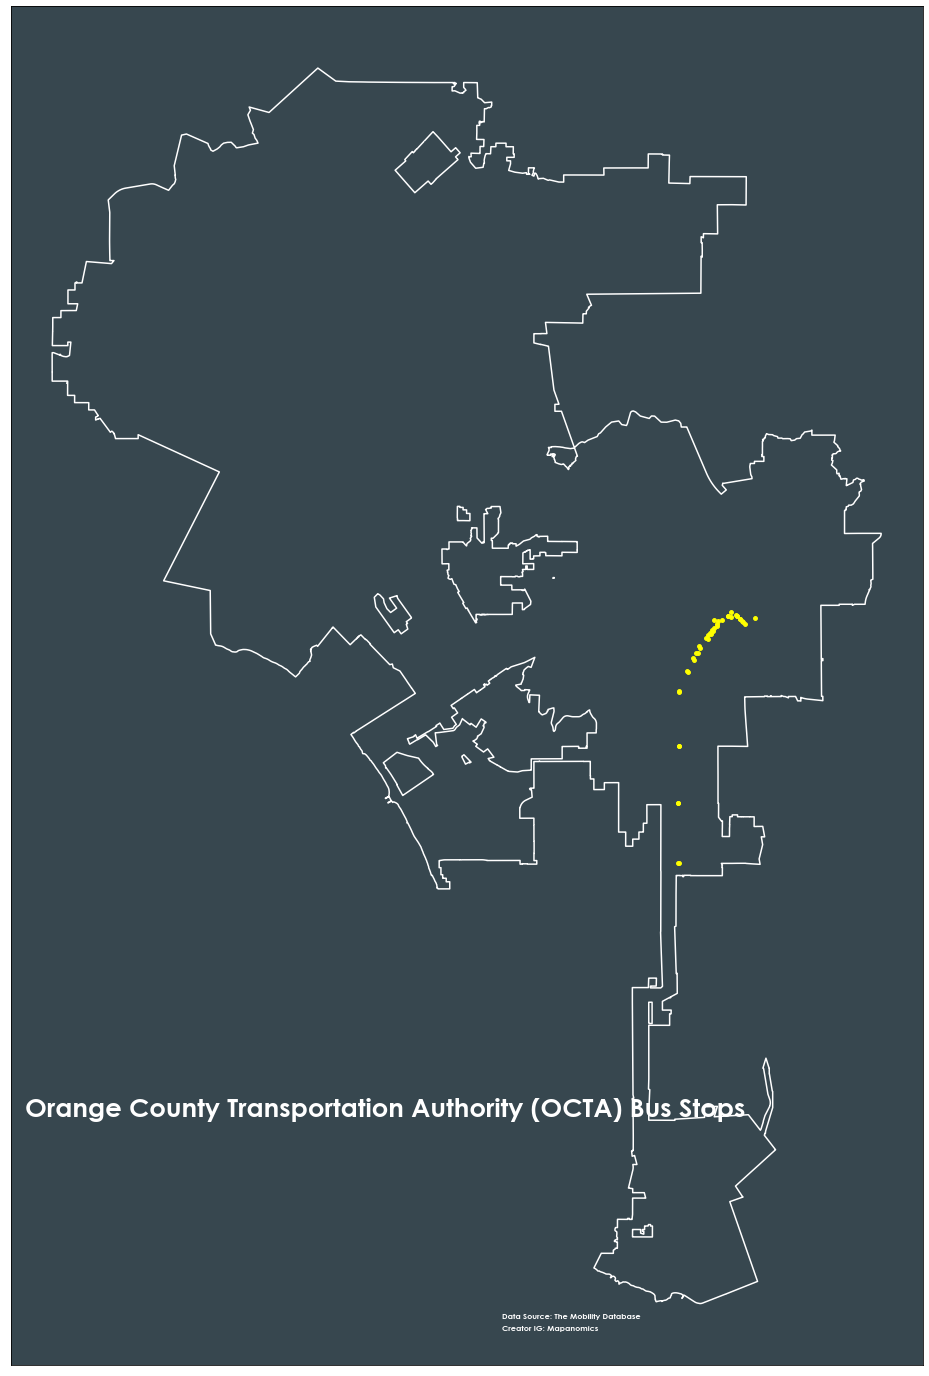

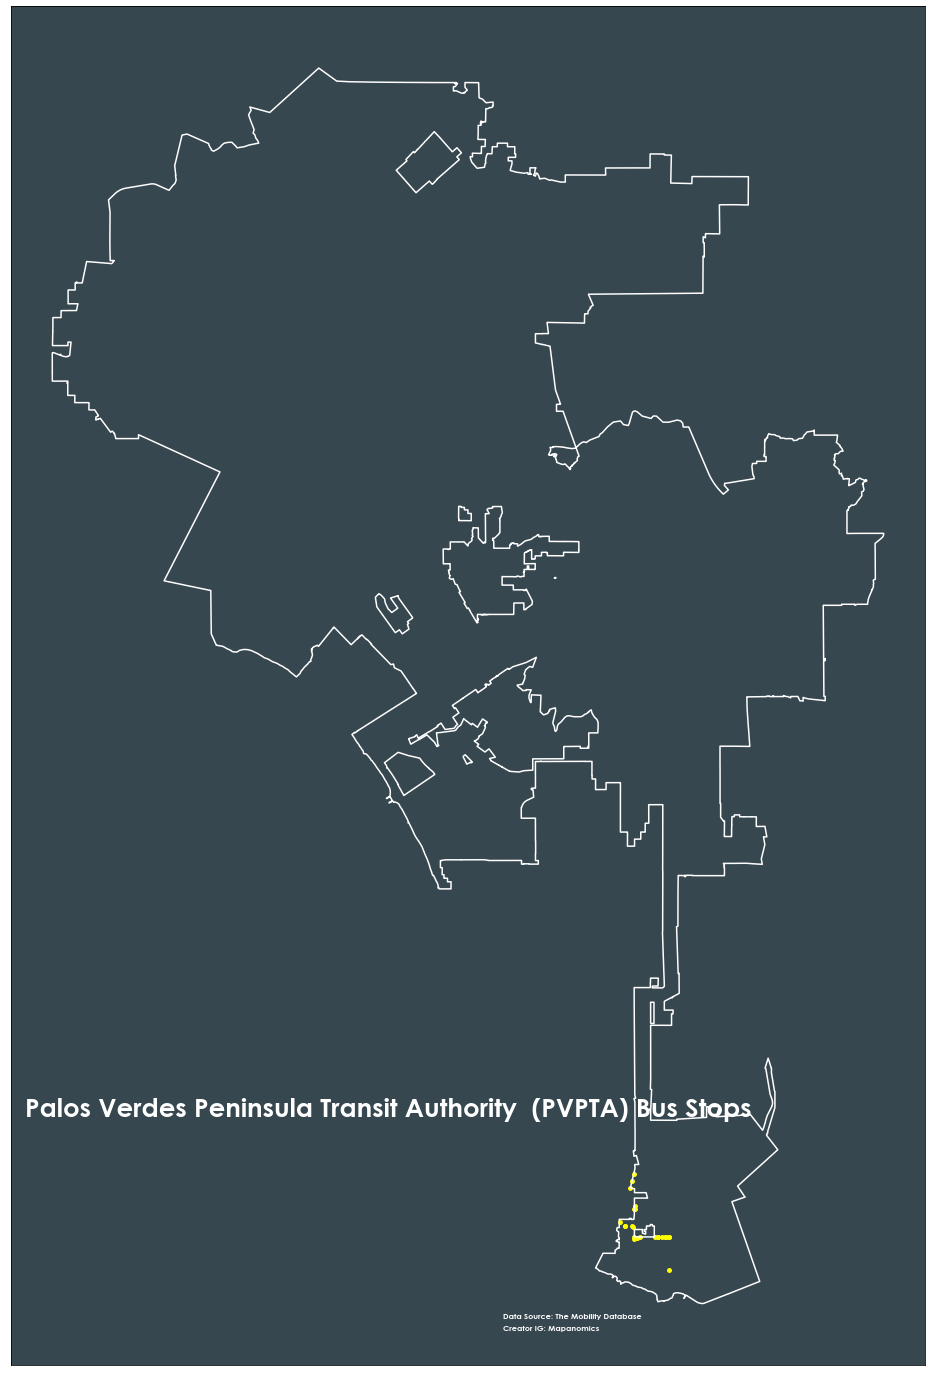

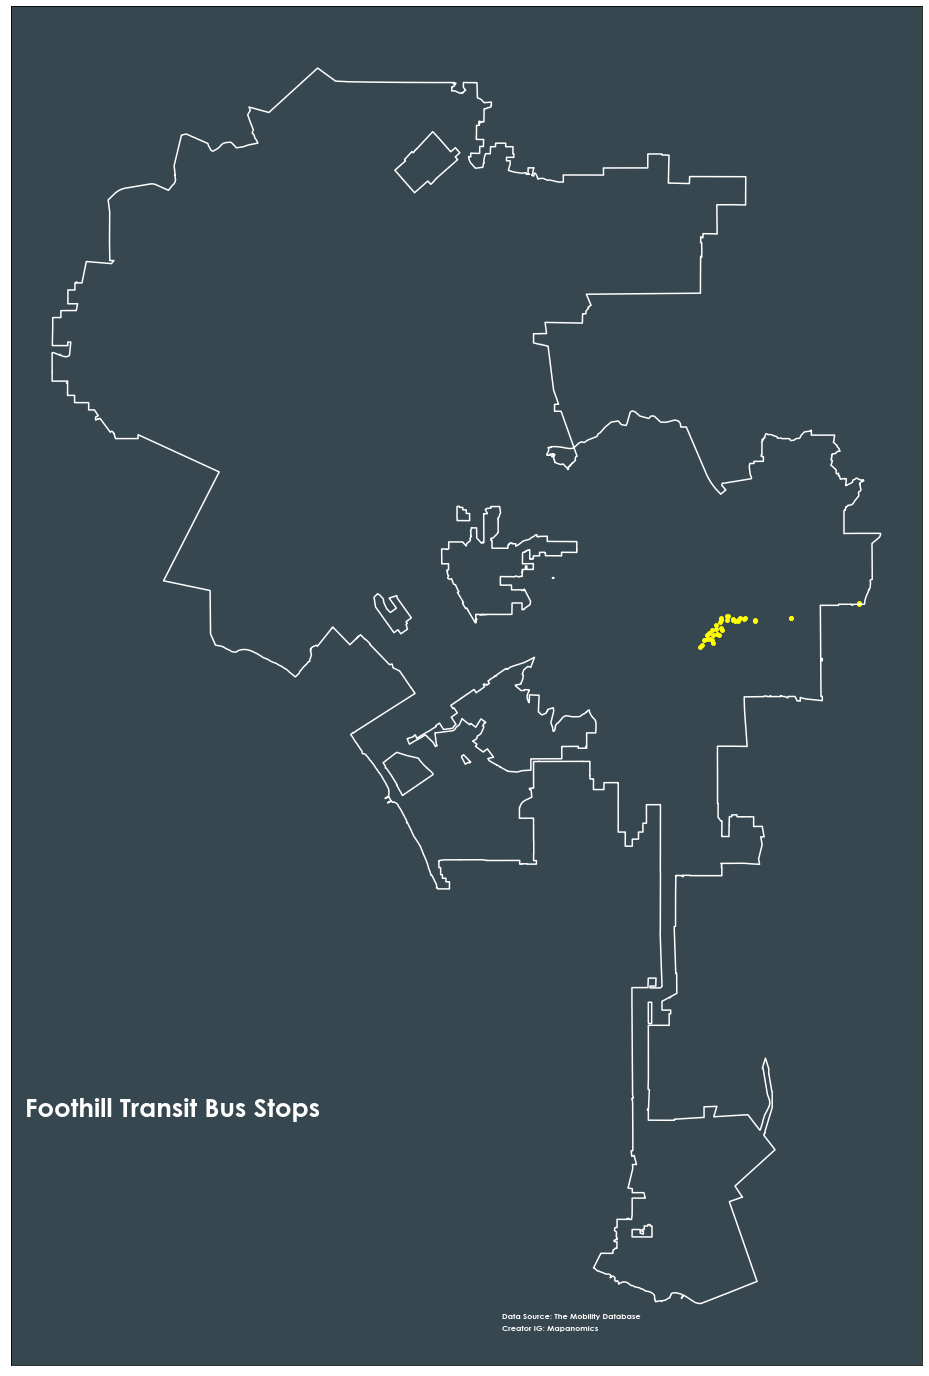

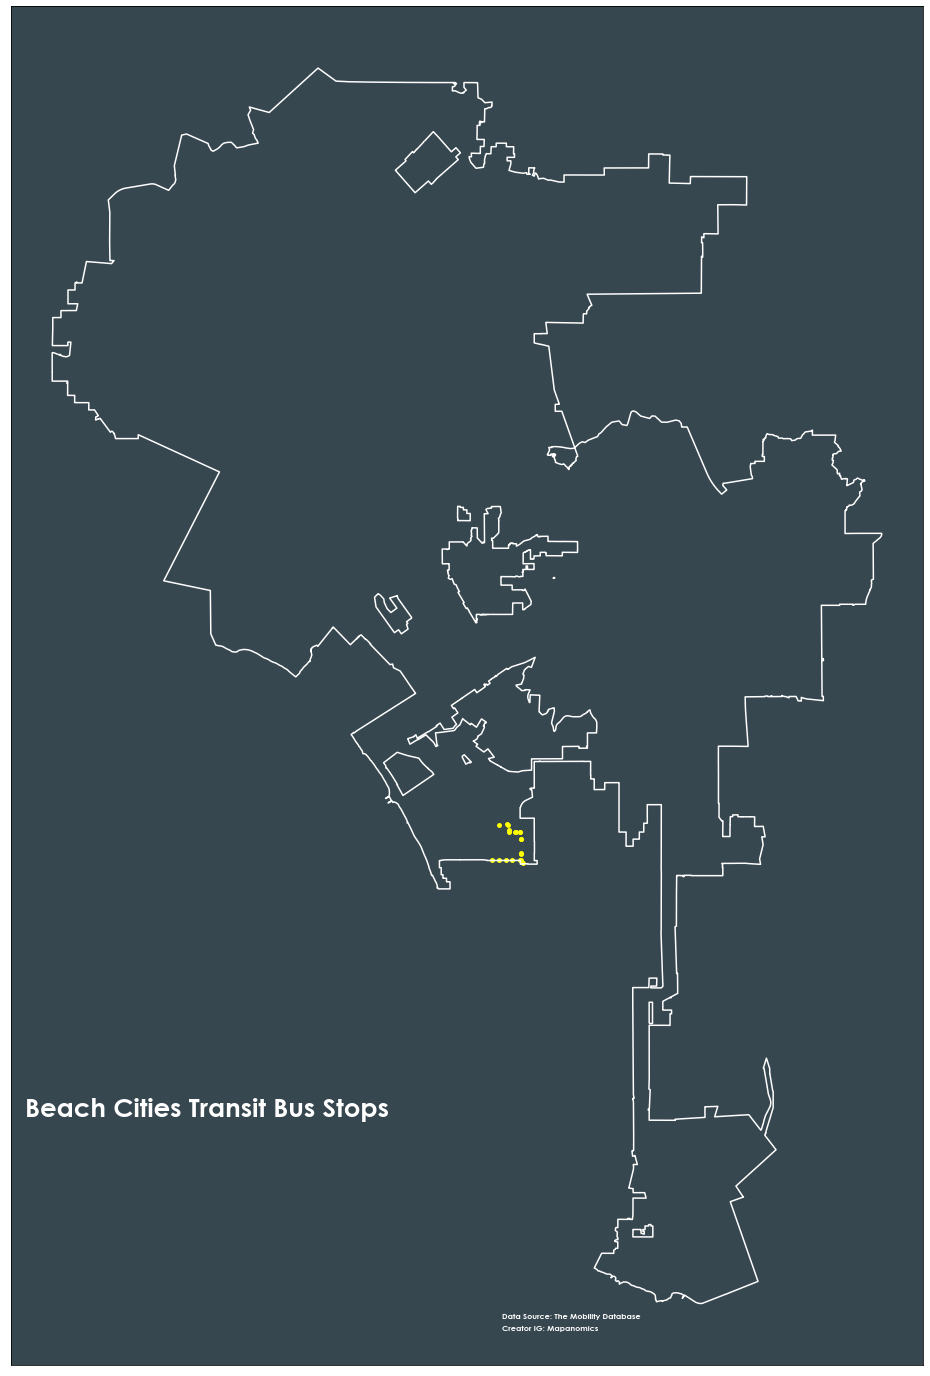

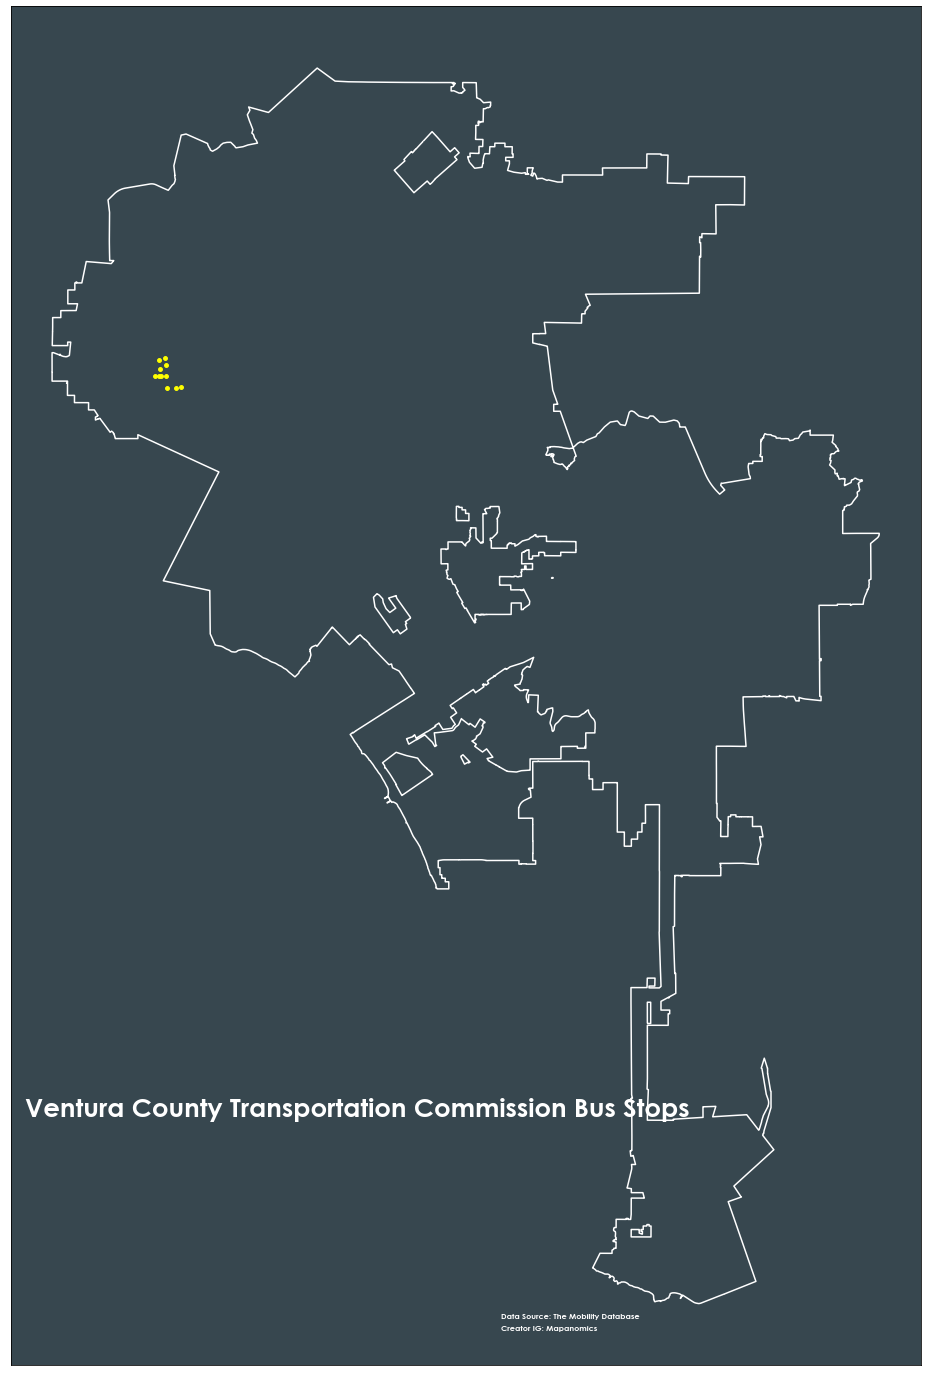

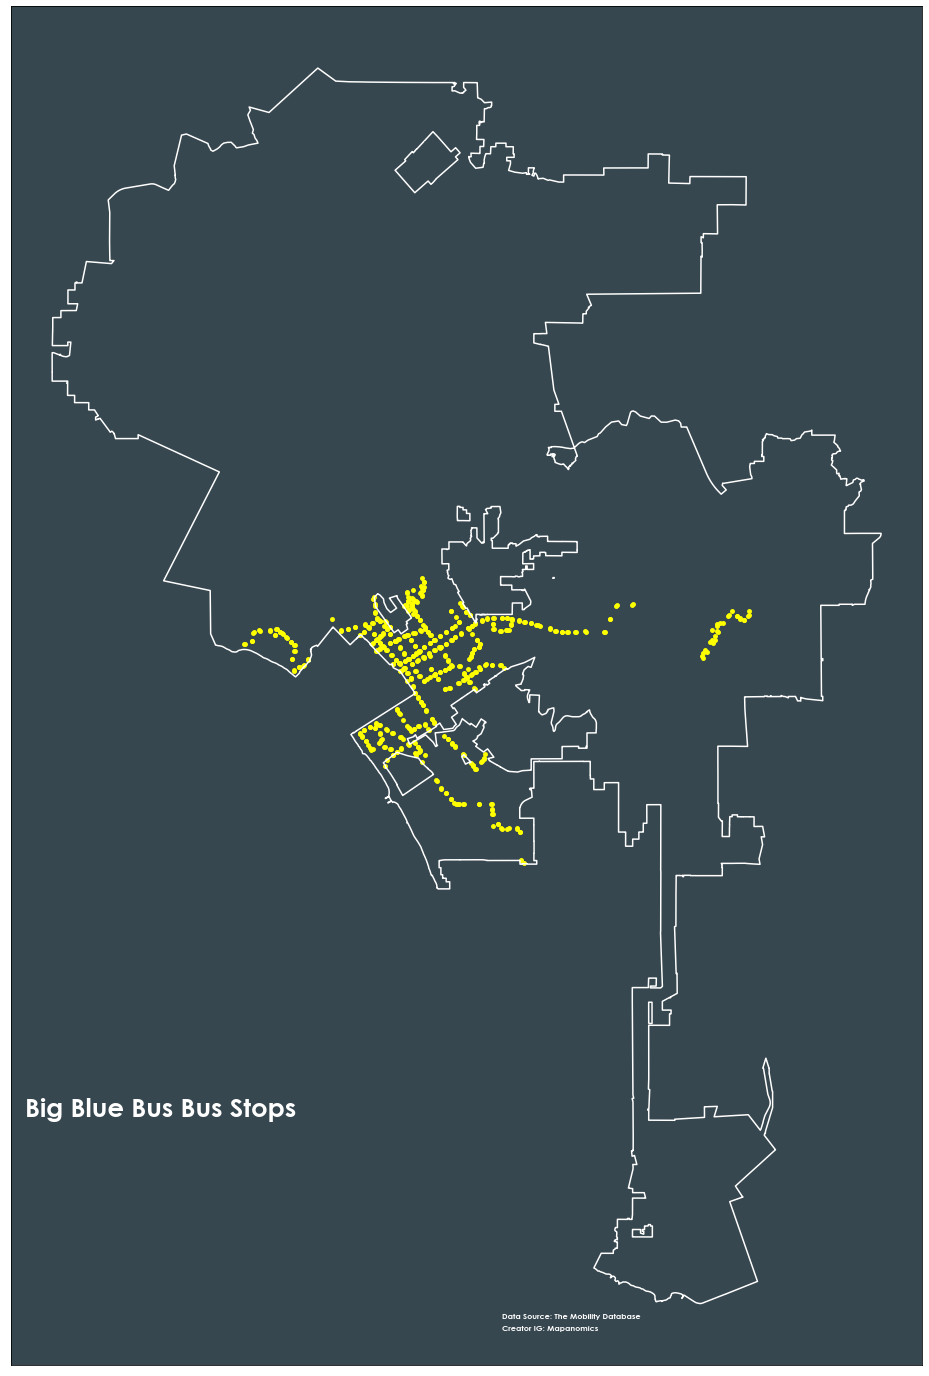

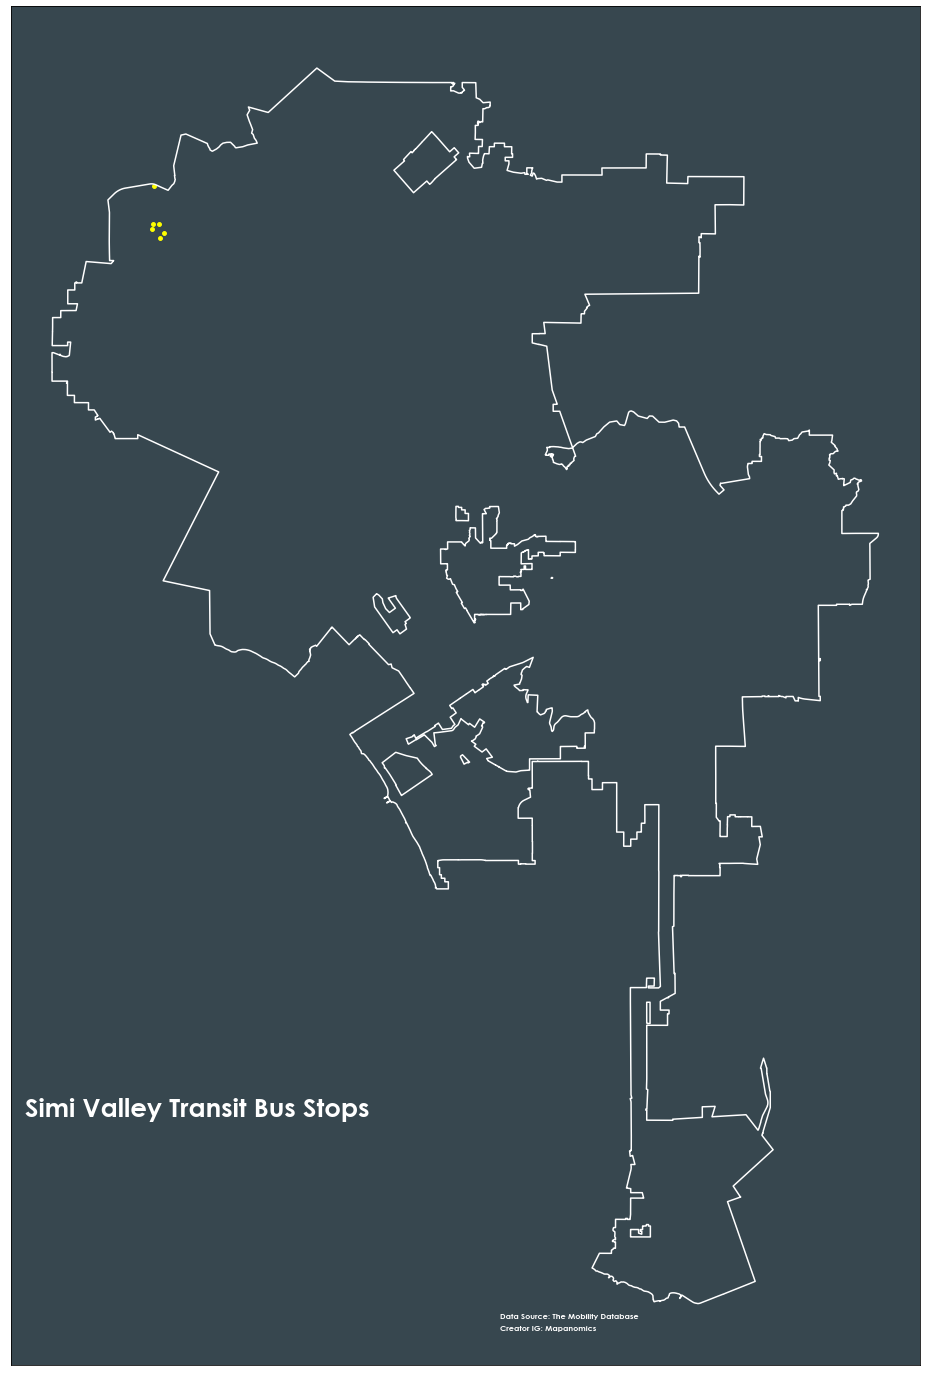

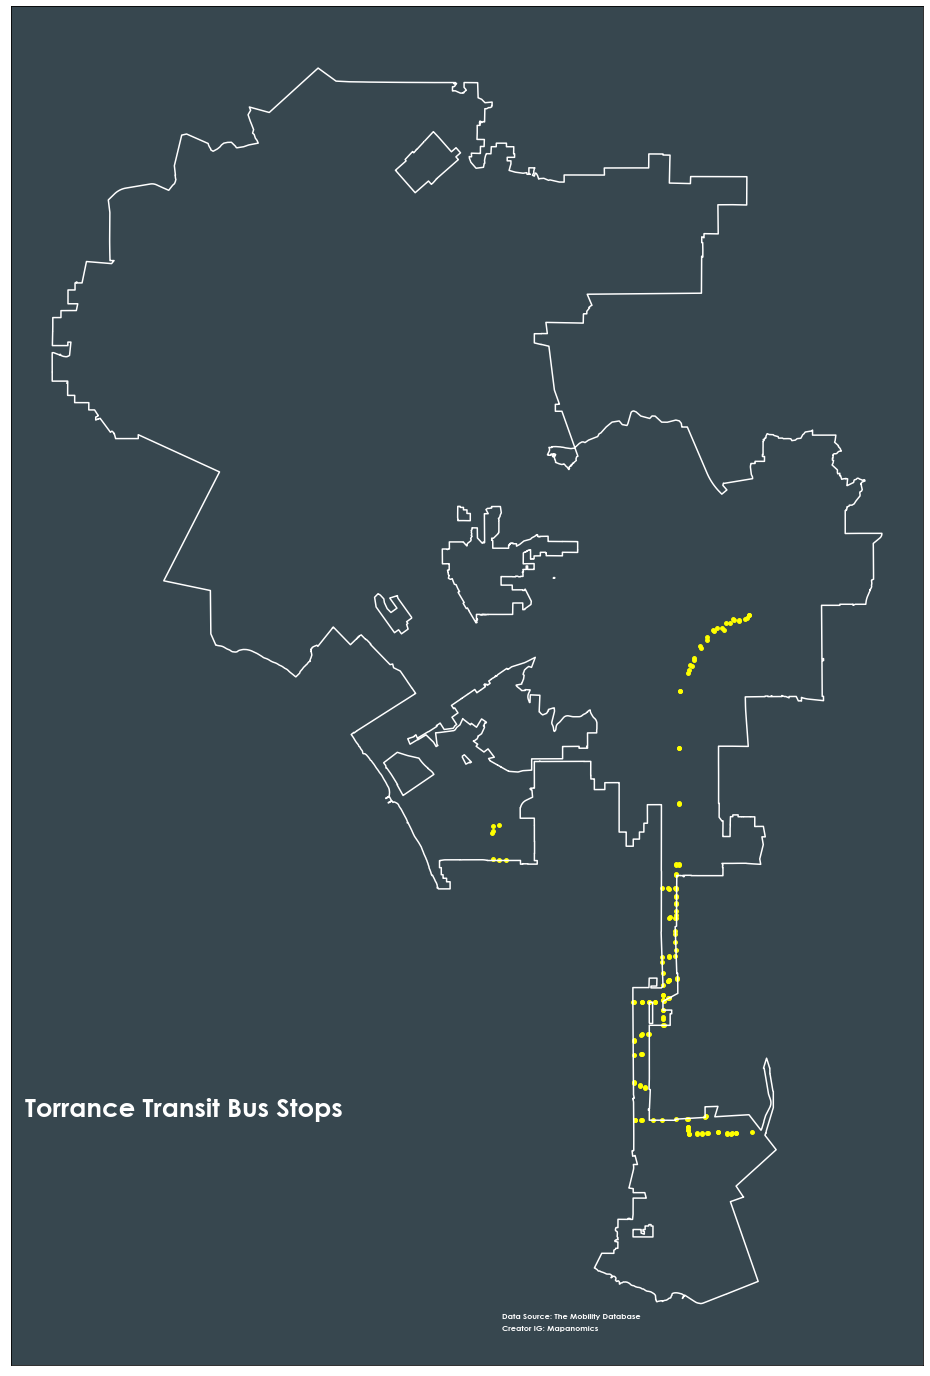

In [148]:
for agency in list(la_bus_stops['Agency_Transit'].unique()):
    leg_args = {'loc':'best', 
            'labelcolor':'white',
            'edgecolor':'white',
            'facecolor':'#37474F',
            'fontsize':'medium',
            'prop': {'size': 10}}

    agency_query = la_bus_stops[la_bus_stops['Agency_Transit']== agency]
    
    #texts =[ax.text(row.coords[0], row.coords[1], 
     #       fontstyle="italic",fontsize=12, fontweight='bold',color='white', 
      #      s=row["NAME_ALF"], horizontalalignment='center',
       #     path_effects=[pe.withStroke(linewidth=1.8, foreground="black")]) for idx, row in cpa.iterrows()]


    ax = la_city.boundary.plot(figsize=(22,25), color='white')
    ax.annotate(f'{agency} Bus Stops',xy=(-118.685, 33.8), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=26,fontweight='bold')
    # ax.annotate(f'{agency} stops',xy=(-118.63, 33.94), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=12,fontweight='bold')
    ax.annotate('Creator IG: Mapanomics',xy=(-118.39, 33.69), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=8,fontweight='bold')
    ax.annotate('Data Source: The Mobility Database',xy=(-118.39, 33.696), xycoords='data', color='white', fontfamily="Century Gothic",fontsize=8,fontweight='bold')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    agency_query.plot(ax=ax, column='Agency_Transit', color= 'yellow', markersize=15, legend=True,legend_kwds=leg_args)
    ax.set_facecolor('#37474F')
    plt.savefig(f'{agency} Bus Stops.png',dpi=200)
    
    

# Graph

In [150]:
la_bus_stops.head(3)

stop_name   stop_lat    stop_lon  \
77  Paseo Rancho Castilla & Levanda Ave  34.071785 -118.167881   
78  Paseo Rancho Castilla & Levanda Ave  34.071581 -118.168217   
79               Cal State LA Metrolink  34.063212 -118.168373   

                Agency_Transit City_Name                     geometry  
77  Alhambra Community Transit  Alhambra  POINT (-118.16788 34.07178)  
78  Alhambra Community Transit  Alhambra  POINT (-118.16822 34.07158)  
79  Alhambra Community Transit  Alhambra  POINT (-118.16837 34.06321)

In [164]:
# summarize
agency_transit = la_bus_stops.groupby(by='Agency_Transit').count()
agency_transit.reset_index(inplace=True)
agency_transit.rename(columns={"stop_name": "Count"},inplace=True)
agency_transit.sort_values(by='Count')
list(agency_transit['Agency_Transit'])

['Airport Valet Express',
 'Alhambra Community Transit',
 'Antelope Valley Transit Authority (AVTA)',
 'Beach Cities Transit',
 'Big Blue Bus',
 'Calabasas Transit System',
 'Commerce Municipal Bus Lines',
 'Culver City Bus',
 'Foothill Transit',
 'GTrans',
 'LA Metro Rail',
 'Long Beach Transit (LBT)',
 'Los Angeles County Department of Public Works (the LINK and shuttles)',
 'Los Angeles County Metropolitan Transportation Authority',
 'Los Angeles Department of Transportation (LADOT, DASH, Commuter Express)',
 'Montebello Bus Lines',
 'Orange County Transportation Authority (OCTA)',
 'Palos Verdes Peninsula Transit Authority  (PVPTA)',
 'Playa Vista Shuttle',
 'Simi Valley Transit',
 'Spirit Bus',
 'Torrance Transit',
 'Ventura County Transportation Commission']

In [168]:
agency_transit['Agency_Transit'] = agency_transit['Agency_Transit'].replace('Los Angeles County Metropolitan Transportation Authority',
                                          'Metro')
agency_transit['Agency_Transit'] = agency_transit['Agency_Transit'].replace('Palos Verdes Peninsula Transit Authority  (PVPTA)',
                                          'PVPTA')
agency_transit['Agency_Transit'] = agency_transit['Agency_Transit'].replace('Los Angeles Department of Transportation (LADOT, DASH, Commuter Express)',
                                          'LADOT')
agency_transit['Agency_Transit'] = agency_transit['Agency_Transit'].replace('Los Angeles County Department of Public Works (the LINK and shuttles)',
                                          'LADPW')
agency_transit['Agency_Transit'] = agency_transit['Agency_Transit'].replace('Antelope Valley Transit Authority (AVTA)',
                                          'AVTA')
agency_transit['Agency_Transit'] = agency_transit['Agency_Transit'].replace('Orange County Transportation Authority (OCTA)',
                                          'OCTA')
agency_transit['Agency_Transit'] = agency_transit['Agency_Transit'].replace('Ventura County Transportation Commission',
                                          'VCTC')

Text(0.5, 1.0, 'Bus Stop Transit Agencies')

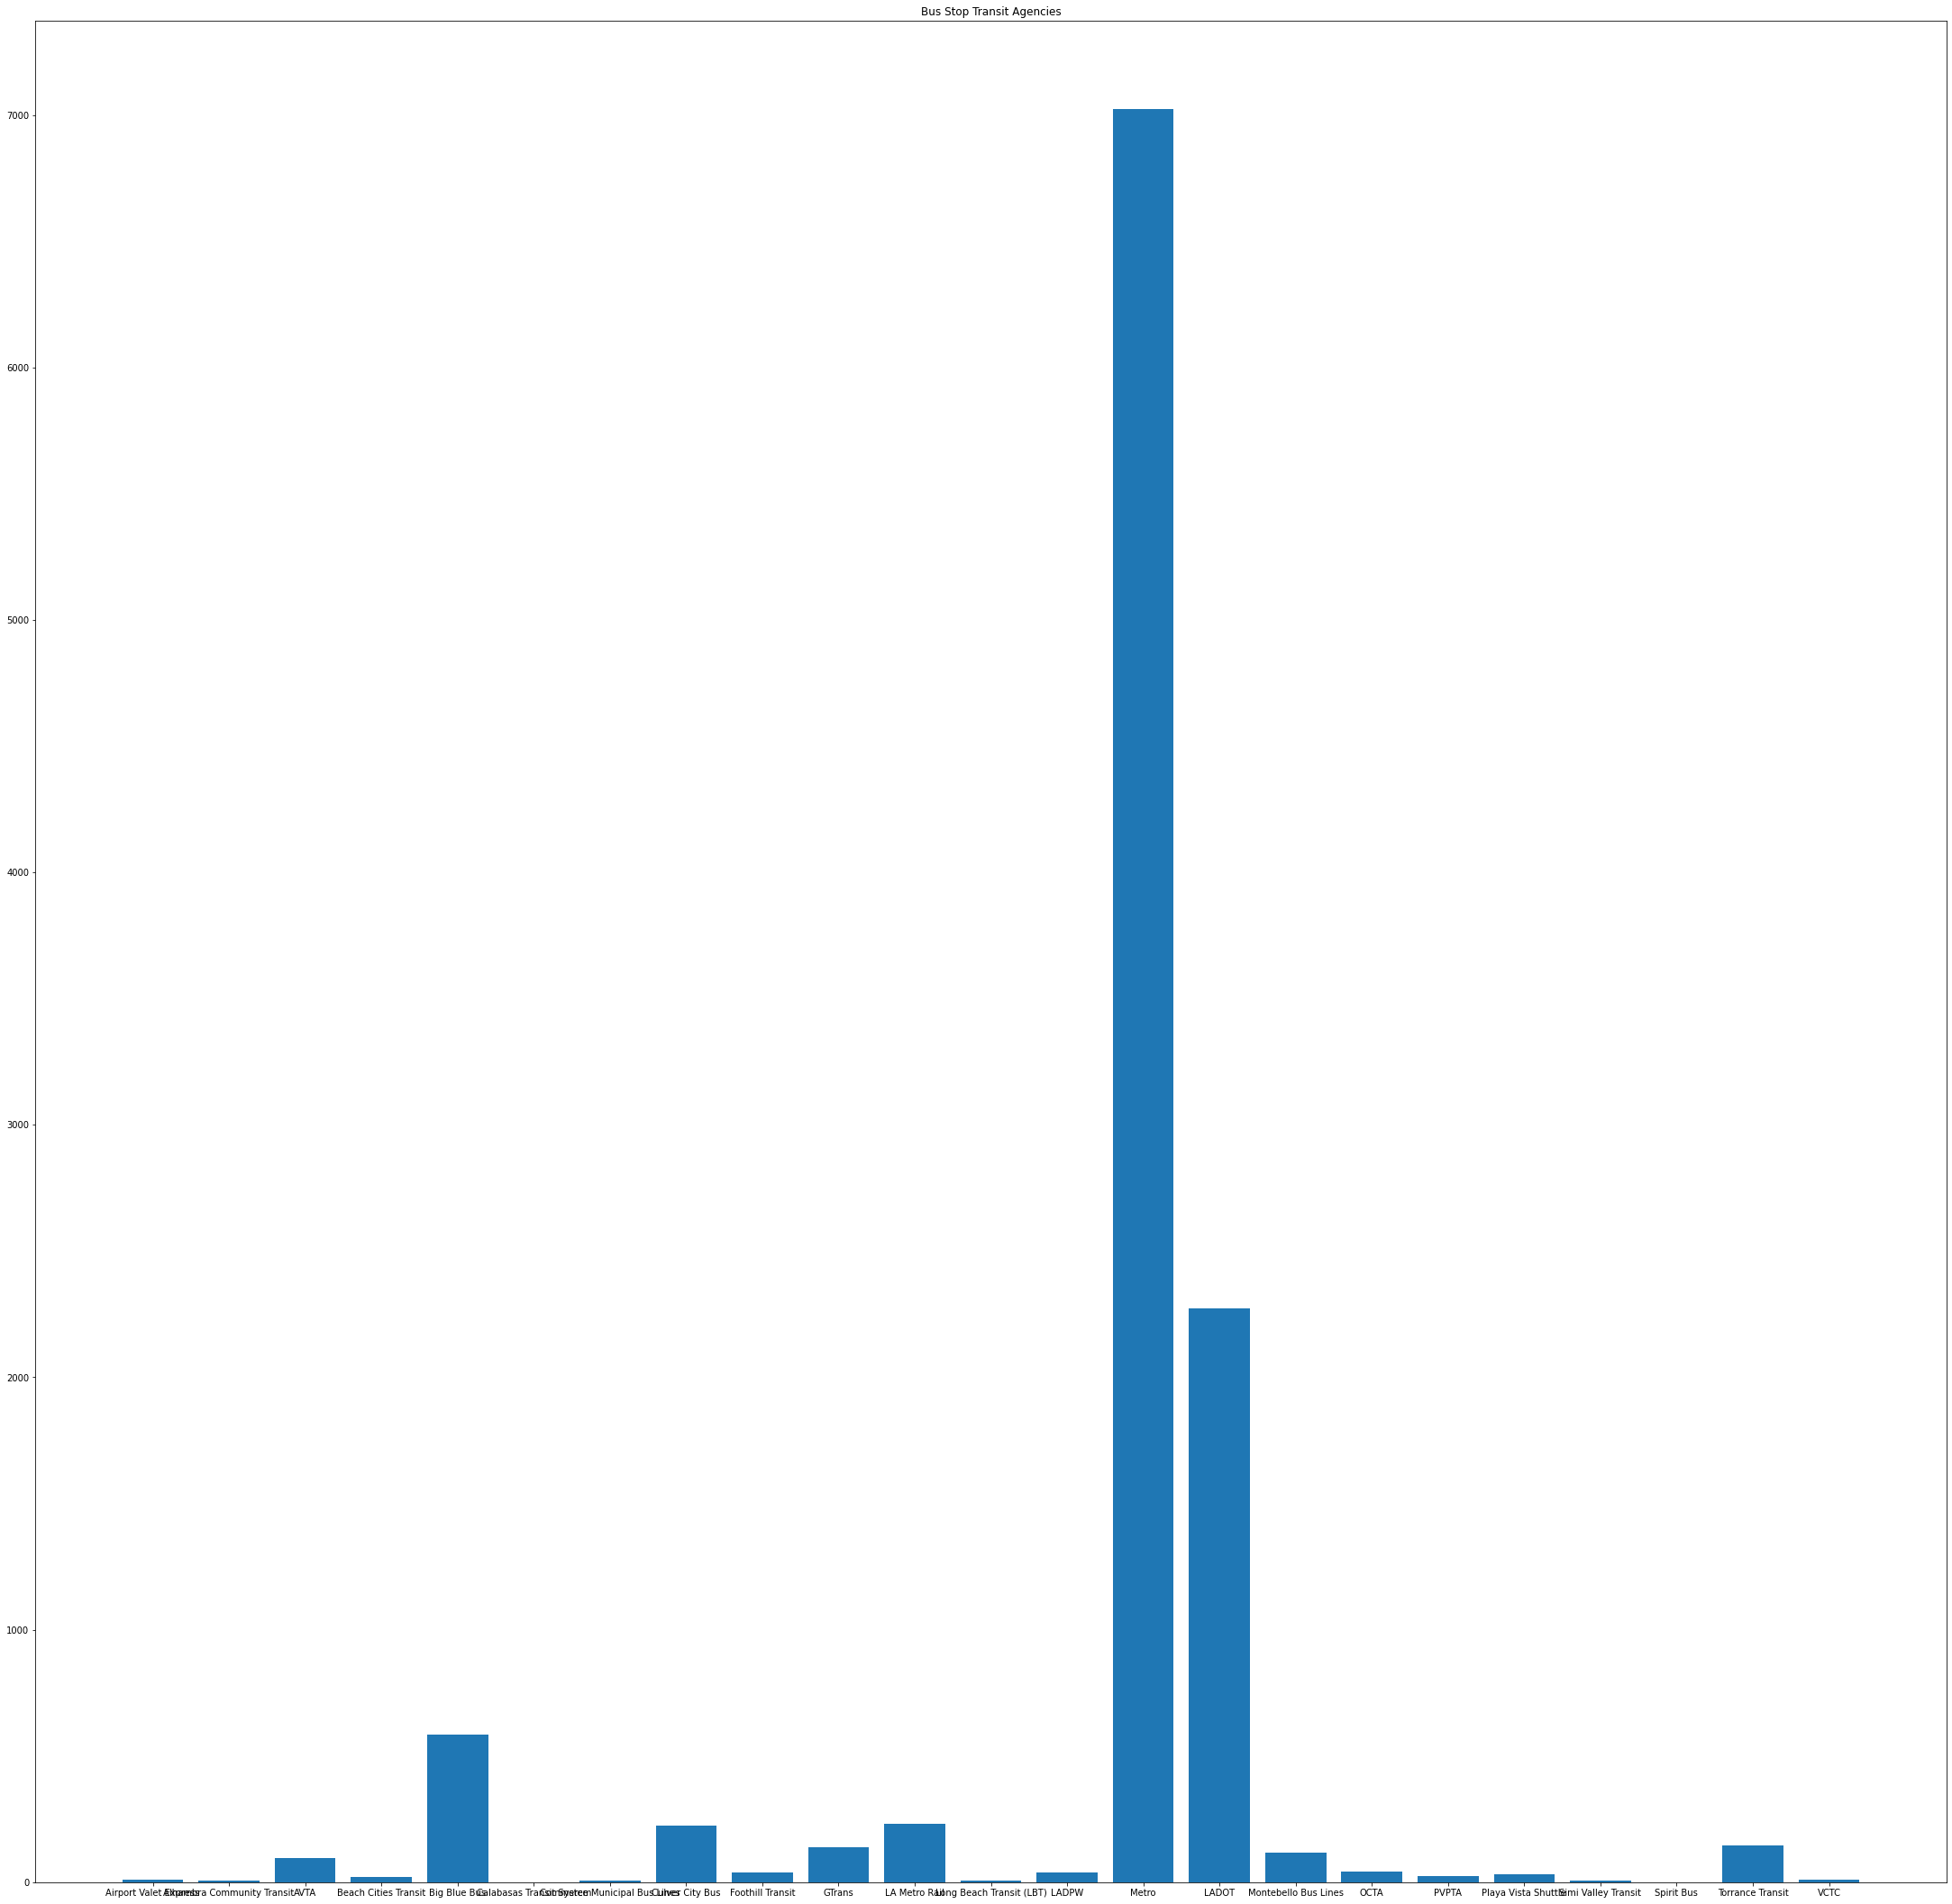

In [170]:
fig,axs= plt.subplots(figsize=(38,38))

plt.bar(x='Agency_Transit',height='Count', data=agency_transit)
plt.title('Bus Stop Transit Agencies')

In [196]:
greater_20 = agency_transit[(agency_transit['Count'] > 20) & (agency_transit['Agency_Transit'] !='LA Metro Rail')]
greater_20

Agency_Transit  Count  stop_lat  stop_lon  City_Name  geometry
2                   AVTA     96        96        96         96        96
4           Big Blue Bus    585       585       585        585       585
7        Culver City Bus    225       225       225        225       225
8       Foothill Transit     37        37        37         37        37
9                 GTrans    137       137       137        137       137
12                 LADPW     40        40        40         40        40
13                 Metro   7022      7022      7022       7022      7022
14                 LADOT   2272      2272      2272       2272      2272
15  Montebello Bus Lines    118       118       118        118       118
16                  OCTA     42        42        42         42        42
17                 PVPTA     25        25        25         25        25
18   Playa Vista Shuttle     32        32        32         32        32
21      Torrance Transit    146       146       146        146       146

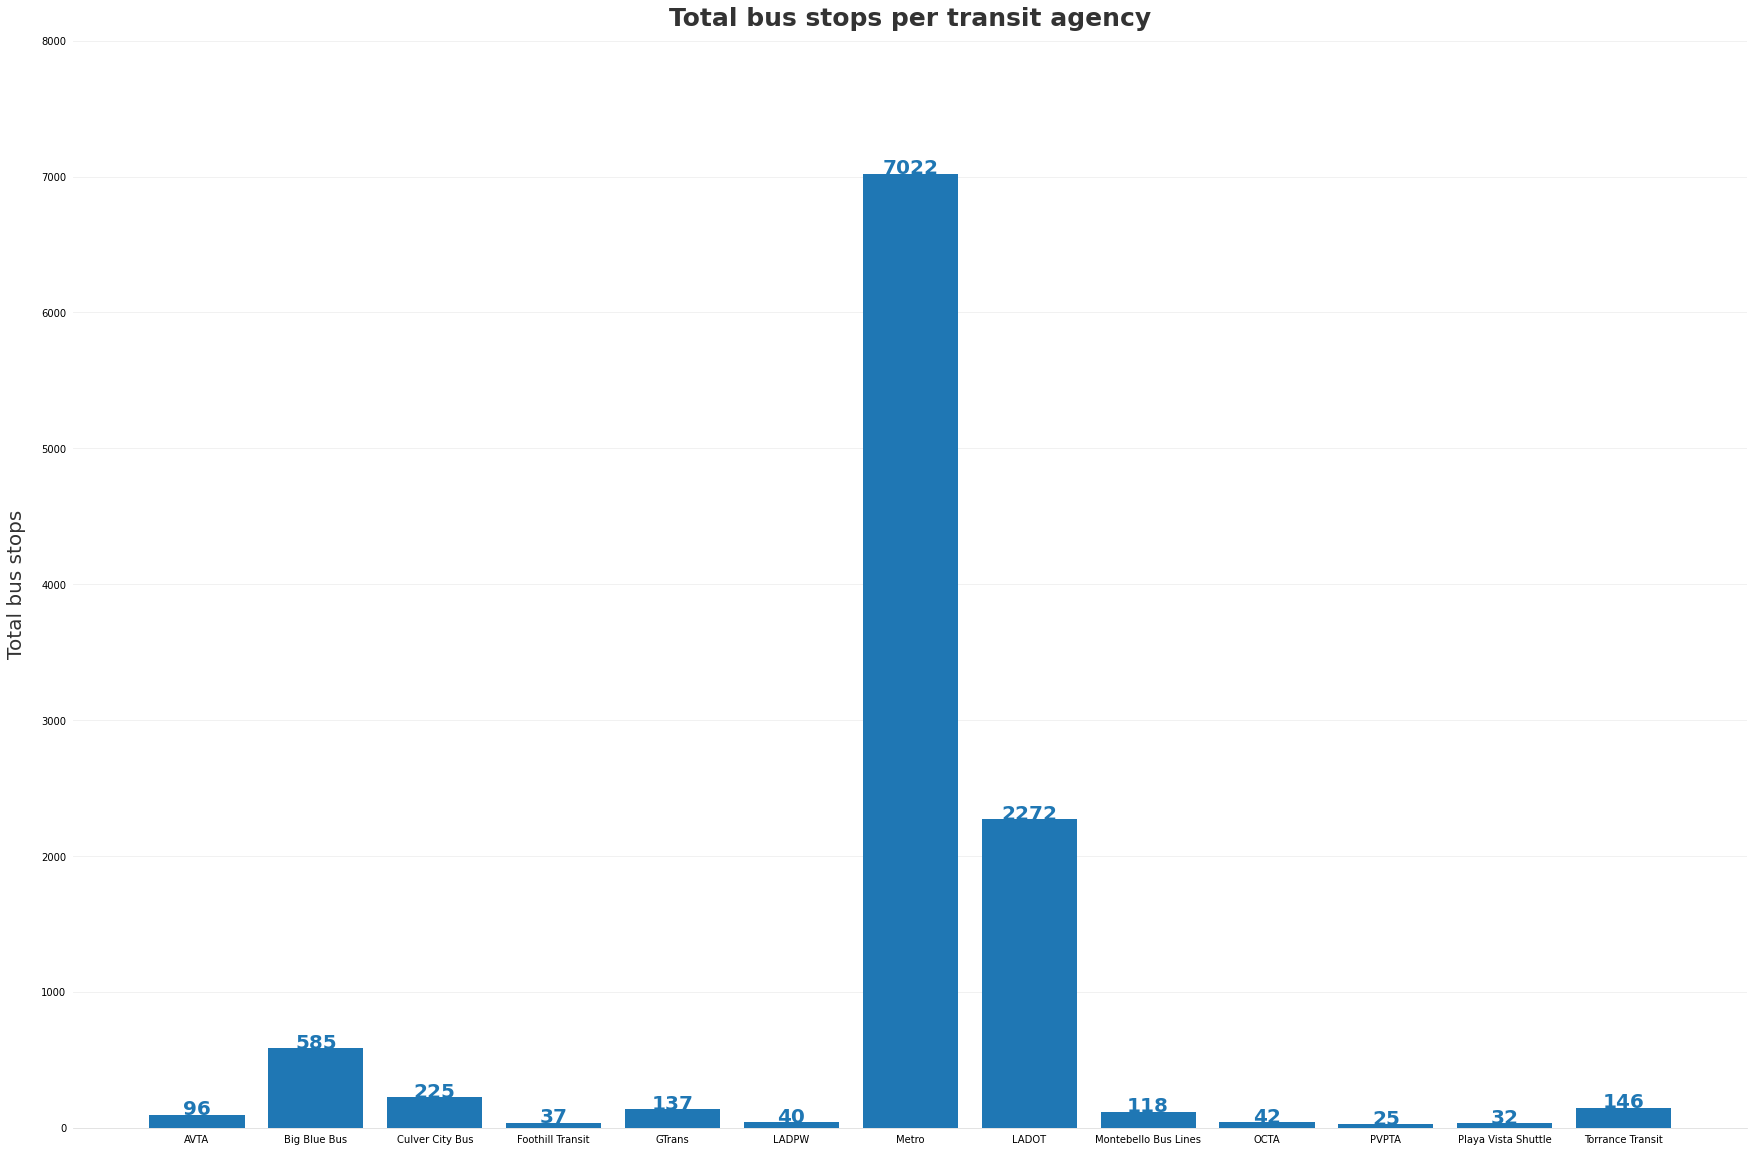

In [225]:
fig, ax = plt.subplots(figsize=(30,20))

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x= greater_20['Agency_Transit'],
    height=greater_20['Count'],
    tick_label=greater_20['Agency_Transit']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold',
      size=20
    )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_ylabel('Total bus stops', labelpad=15, color='#333333', size=20)
ax.set_title('Total bus stops per transit agency', pad=15, color='#333333', size=25,
             weight='bold')

plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')

plt.savefig(f'Bus Stops.jpeg',dpi=200)
plt.show()

In [91]:
la_bus_stops.to_csv('la_bus_stops.csv', index=True)

In [93]:
la_bus_stops.to_file('LA City Bus Stops.shp')  

C:\Users\luisg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.
